In [7]:
# import os
from tqdm import trange
# import wandb

# import re
import gymnasium as gym
# from llamagym import Agent
import numpy as np
import d3rlpy
import pickle

from gymnasium_env import BlackjackWrapper
import matplotlib.pyplot as plt

class InputParams:
    def __init__(self):
        self.env="Blackjack-v1"
        self.seed=1
        self.gpu=True

args=InputParams()
n_pretrain_eps = 125
n_online_eps = 375

# d3rlpy supports both Gym and Gymnasium
if args.env=="Blackjack-v1":
    env = BlackjackWrapper(gym.make("Blackjack-v1"))
    eval_env = BlackjackWrapper(gym.make("Blackjack-v1"))
else:
    env = gym.make(args.env)
    eval_env = gym.make(args.env)

# # fix seed
# d3rlpy.seed(args.seed)
# d3rlpy.envs.seed_env(env, args.seed)
# d3rlpy.envs.seed_env(eval_env, args.seed)

## Offline pretraining

In [8]:
# # setup algorithm
# llama_dqn = d3rlpy.algos.DQNConfig(
#     batch_size=32,
#     learning_rate=6.25e-5,
#     ).create(device=args.gpu)

# with open('data/random_eps_5000.pkl', 'rb') as file:
# # with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
# # with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
#     dataset = pickle.load(file)

# # start offline training
# llama_dqn.fit(dataset, n_steps=1300) #Around 500 eps here

# with open('models/dqn_random_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_Qwen2.5-0.5B_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_llama_eps_500.pkl', 'wb') as file:
#         pickle.dump(llama_dqn, file)

## Load pretrained model and online training

In [9]:
def online_training(
    env,
    eval_env,
    explorer=None,
    model_path=None,
    model=None,
    data_path=None,
    n_pretrain_eps=125,
    limit=1000000,
    n_steps=1050, # Online training ~375 eps
    n_steps_per_epoch=100,
    update_interval=1,
    cut_off_threshold=(125,500),
    gpu=True
):
    # Load model with proper validation
    if model_path:
        with open(model_path, 'rb') as file:
            dqn = pickle.load(file)
    elif model:
        dqn = model
    else:
        dqn = d3rlpy.algos.DQNConfig(
            batch_size=32,
            learning_rate=6.25e-5,
            ).create(device=gpu)

    # Initialize empty FIFO buffer
    buffer = d3rlpy.dataset.ReplayBuffer(
        buffer=d3rlpy.dataset.FIFOBuffer(limit=limit),
        env=env,
    )
    
    # Load and merge offline data with type-checking
    if data_path:
        try:
            # Load dataset with proper validation
            with open(data_path, 'rb') as f:
                dataset = pickle.load(f)
            
            # Verify dataset structure
            if hasattr(dataset, 'episodes'):
                # Calculate safe episode count to load
                valid_episodes = min(n_pretrain_eps, len(dataset.episodes))
                
                # Append episodes with transition validation
                for episode in dataset.episodes[:valid_episodes]:
                    if len(episode) > 0 and hasattr(episode, 'rewards'):
                        buffer.append_episode(episode)
                    else:
                        print(f"Skipping invalid episode: {episode}")
        except Exception as e:
            print(f"Error loading dataset: {str(e)}")

    # Configure training with safety checks
    if buffer.transition_count == 0:
        print("Empty buffer (just Online training)!")
    dqn.fit_online(
        env=env,
        buffer=buffer,
        explorer=explorer,
        eval_env=eval_env,
        n_steps=n_steps,
        n_steps_per_epoch=n_steps_per_epoch,
        update_interval=update_interval,
        experiment_name="online_training",
    )

    # Extract rewards safely
    rewards = []
    for episode in buffer.episodes: # Only collect the online data
        if hasattr(episode, 'rewards') and episode.rewards.size > 0:
            rewards.extend(episode.rewards.flatten().tolist())
    
    start, end = cut_off_threshold
    return rewards[start:end]

## Data collection

### Static/pretrain data

In [10]:
with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
    Qwen_dataset = pickle.load(file)
    
with open('data/random_eps_5000.pkl', 'rb') as file:
    rand_dataset = pickle.load(file)
    
with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
    llama_dataset = pickle.load(file)

Qwen_rewards = []
for i in range(n_pretrain_eps):
    Qwen_rewards.append(Qwen_dataset.episodes[i].rewards[0,0])
rand_rewards = []
for i in range(n_pretrain_eps):
    rand_rewards.append(rand_dataset.episodes[i].rewards[0,0])
llama_rewards = []
for i in range(n_pretrain_eps):
    llama_rewards.append(llama_dataset.episodes[i].rewards[0,0])

Qwen_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_rewards)
rand_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(rand_rewards)
llama_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(llama_rewards)

### Online data

In [13]:
n_exp = 5
llama_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
Qwen_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
rand_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
onl_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
onl_rewards_eps = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
onl_rewards_eps_decay = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# setup explorers
const_explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.3)
decay_explorer = d3rlpy.algos.LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=200,
)
for i in range(n_exp):
    # llama_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
    # Qwen_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/Qwen2.5-0.5B_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
    # rand_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/random_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps) #list length 250 here
    onl_rewards[:,i] = online_training(env, eval_env, n_steps=1400, cut_off_threshold=(0,500)) #list length 500 here
    onl_rewards_eps[:,i] = online_training(env, eval_env, const_explorer, n_steps=1400, cut_off_threshold=(0,500)) #list length 500 here
    onl_rewards_eps_decay[:,i] = online_training(env, eval_env, decay_explorer, n_steps=1400, cut_off_threshold=(0,500)) #list length 500 here

2025-03-27 22:37.56 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:37.57 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:37.57 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:37.57 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223757
2025-03-27 22:37.57 [debug    ] Building model...             
2025-03-27 22:37.57 [debug    ] Model has been built.         
2025-03-27 22:37.57 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s

  4%|▍         | 53/1400 [00:00<00:02, 516.75it/s]

2025-03-27 22:37.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_100.d3
2025-03-27 22:37.57 [info     ] online_training_20250327223757: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0004677081108093262, 'time_environment_step': 4.636764526367187e-05, 'rollout_return': -0.4246575342465753, 'time_step': 0.002768385410308838, 'time_sample_batch': 0.0004316194733576988, 'time_algorithm_update': 0.0027995500991593544, 'loss': 0.5161397901933584, 'evaluation': -0.4} step=100


 12%|█▏        | 173/1400 [00:00<00:04, 262.23it/s]

2025-03-27 22:37.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_200.d3
2025-03-27 22:37.57 [info     ] online_training_20250327223757: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005611228942871094, 'time_environment_step': 5.182266235351563e-05, 'rollout_return': -0.14084507042253522, 'time_sample_batch': 0.00042639493942260744, 'time_algorithm_update': 0.0032170748710632323, 'loss': 0.42535713747143744, 'time_step': 0.004350261688232422, 'evaluation': -0.1} step=200


 21%|██▏       | 299/1400 [00:01<00:04, 231.22it/s]

2025-03-27 22:37.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_300.d3
2025-03-27 22:37.58 [info     ] online_training_20250327223757: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000547482967376709, 'time_environment_step': 5.5899620056152346e-05, 'rollout_return': -0.17333333333333334, 'time_sample_batch': 0.0004606366157531738, 'time_algorithm_update': 0.00314622163772583, 'loss': 0.42428291216492653, 'time_step': 0.004320113658905029, 'evaluation': 0.0} step=300


 28%|██▊       | 396/1400 [00:01<00:04, 232.41it/s]

2025-03-27 22:37.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_400.d3
2025-03-27 22:37.58 [info     ] online_training_20250327223757: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005318164825439453, 'time_environment_step': 5.4237842559814455e-05, 'rollout_return': -0.1891891891891892, 'time_sample_batch': 0.0004593372344970703, 'time_algorithm_update': 0.0030390453338623048, 'loss': 0.4475677418708801, 'time_step': 0.004189784526824951, 'evaluation': -0.2} step=400


 35%|███▌      | 493/1400 [00:02<00:03, 232.42it/s]

2025-03-27 22:37.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_500.d3
2025-03-27 22:37.59 [info     ] online_training_20250327223757: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005193138122558593, 'time_environment_step': 5.022287368774414e-05, 'rollout_return': -0.05333333333333334, 'time_sample_batch': 0.0004611897468566894, 'time_algorithm_update': 0.0030856084823608397, 'loss': 0.44850032299757003, 'time_step': 0.004221367835998535, 'evaluation': -0.4} step=500


 42%|████▏     | 590/1400 [00:02<00:03, 233.74it/s]

2025-03-27 22:37.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_600.d3
2025-03-27 22:37.59 [info     ] online_training_20250327223757: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005138158798217773, 'time_environment_step': 4.848003387451172e-05, 'time_sample_batch': 0.00045213699340820315, 'time_algorithm_update': 0.003078913688659668, 'loss': 0.4423414681851864, 'time_step': 0.004192457199096679, 'rollout_return': -0.08333333333333333, 'evaluation': 0.0} step=600


 49%|████▉     | 686/1400 [00:02<00:03, 229.73it/s]

2025-03-27 22:37.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_700.d3
2025-03-27 22:37.59 [info     ] online_training_20250327223757: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005020809173583985, 'time_environment_step': 5.065202713012695e-05, 'rollout_return': -0.2125, 'time_sample_batch': 0.0004490804672241211, 'time_algorithm_update': 0.003135981559753418, 'loss': 0.45596171438694, 'time_step': 0.0042417311668396, 'evaluation': -0.5} step=700


 56%|█████▌    | 780/1400 [00:03<00:02, 227.21it/s]

2025-03-27 22:38.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_800.d3
2025-03-27 22:38.00 [info     ] online_training_20250327223757: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005342459678649902, 'time_environment_step': 5.135059356689453e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.000460813045501709, 'time_algorithm_update': 0.003140254020690918, 'loss': 0.4563081841170788, 'time_step': 0.004290292263031006, 'evaluation': -0.7} step=800


 64%|██████▍   | 898/1400 [00:03<00:02, 227.56it/s]

2025-03-27 22:38.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_900.d3
2025-03-27 22:38.00 [info     ] online_training_20250327223757: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005626440048217774, 'time_environment_step': 4.9498081207275394e-05, 'rollout_return': -0.07894736842105263, 'time_sample_batch': 0.00045894622802734376, 'time_algorithm_update': 0.0031730151176452637, 'loss': 0.4524320375919342, 'time_step': 0.004348697662353515, 'evaluation': -0.3} step=900


 71%|███████   | 990/1400 [00:04<00:01, 224.37it/s]

2025-03-27 22:38.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_1000.d3
2025-03-27 22:38.01 [info     ] online_training_20250327223757: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005362129211425781, 'time_environment_step': 5.014419555664062e-05, 'rollout_return': -0.027777777777777776, 'time_sample_batch': 0.0004600167274475098, 'time_algorithm_update': 0.0031746816635131836, 'loss': 0.4411638990044594, 'time_step': 0.00432227611541748, 'evaluation': 0.4} step=1000


 78%|███████▊  | 1085/1400 [00:04<00:01, 228.68it/s]

2025-03-27 22:38.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_1100.d3
2025-03-27 22:38.01 [info     ] online_training_20250327223757: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0004910707473754882, 'time_environment_step': 4.87518310546875e-05, 'time_sample_batch': 0.00045859098434448243, 'time_algorithm_update': 0.0031564164161682127, 'loss': 0.4529078757762909, 'time_step': 0.004251372814178467, 'rollout_return': 0.08333333333333333, 'evaluation': 0.0} step=1100


 84%|████████▍ | 1180/1400 [00:05<00:00, 228.37it/s]

2025-03-27 22:38.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_1200.d3
2025-03-27 22:38.02 [info     ] online_training_20250327223757: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005453300476074219, 'time_environment_step': 4.9591064453125e-05, 'rollout_return': -0.06172839506172839, 'time_sample_batch': 0.00045734405517578125, 'time_algorithm_update': 0.0031029582023620605, 'loss': 0.4450604453682899, 'time_step': 0.004261612892150879, 'evaluation': 0.1} step=1200


 93%|█████████▎| 1299/1400 [00:05<00:00, 230.57it/s]

2025-03-27 22:38.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_1300.d3
2025-03-27 22:38.02 [info     ] online_training_20250327223757: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005420517921447754, 'time_environment_step': 5.11622428894043e-05, 'rollout_return': -0.2028985507246377, 'time_sample_batch': 0.0004636549949645996, 'time_algorithm_update': 0.0031081104278564455, 'loss': 0.44103605195879936, 'time_step': 0.004264276027679443, 'evaluation': 0.3} step=1300


 99%|█████████▉| 1391/1400 [00:06<00:00, 221.93it/s]

2025-03-27 22:38.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223757/model_1400.d3
2025-03-27 22:38.03 [info     ] online_training_20250327223757: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005649018287658691, 'time_environment_step': 4.994630813598633e-05, 'time_sample_batch': 0.0004692268371582031, 'time_algorithm_update': 0.0032796502113342286, 'loss': 0.44999322488904, 'time_step': 0.004466061592102051, 'rollout_return': -0.05555555555555555, 'evaluation': -0.2} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 229.67it/s]

2025-03-27 22:38.03 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.03 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.03 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.03 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223803
2025-03-27 22:38.03 [debug    ] Building model...             
2025-03-27 22:38.03 [debug    ] Model has been built.         
2025-03-27 22:38.03 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  7%|▋         | 98/1400 [00:00<00:04, 296.72it/s]

2025-03-27 22:38.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_100.d3
2025-03-27 22:38.03 [info     ] online_training_20250327223803: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005599188804626464, 'time_environment_step': 3.833293914794922e-05, 'rollout_return': -0.5070422535211268, 'time_step': 0.0031812381744384765, 'time_sample_batch': 0.0004434336477251195, 'time_algorithm_update': 0.0032801165509579785, 'loss': 0.6646543020632729, 'evaluation': -0.8} step=100


 13%|█▎        | 188/1400 [00:00<00:05, 230.81it/s]

2025-03-27 22:38.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_200.d3
2025-03-27 22:38.03 [info     ] online_training_20250327223803: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005862355232238769, 'time_environment_step': 4.16254997253418e-05, 'rollout_return': -0.3125, 'time_sample_batch': 0.00047479629516601564, 'time_algorithm_update': 0.003286299705505371, 'loss': 0.6347931033372879, 'time_step': 0.004486279487609863, 'evaluation': -0.4} step=200


 20%|██        | 281/1400 [00:01<00:05, 221.95it/s]

2025-03-27 22:38.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_300.d3
2025-03-27 22:38.04 [info     ] online_training_20250327223803: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005908799171447754, 'time_environment_step': 4.2266845703125e-05, 'time_sample_batch': 0.0004467892646789551, 'time_algorithm_update': 0.0032541894912719725, 'loss': 0.5968765592575074, 'time_step': 0.00443246841430664, 'rollout_return': -0.03076923076923077, 'evaluation': -0.5} step=300


 28%|██▊       | 394/1400 [00:01<00:04, 221.02it/s]

2025-03-27 22:38.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_400.d3
2025-03-27 22:38.04 [info     ] online_training_20250327223803: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005923867225646973, 'time_environment_step': 4.2705535888671876e-05, 'rollout_return': -0.029850746268656716, 'time_sample_batch': 0.0004597115516662598, 'time_algorithm_update': 0.003295016288757324, 'loss': 0.5636511558294296, 'time_step': 0.0044853901863098145, 'evaluation': -0.5} step=400


 35%|███▍      | 488/1400 [00:02<00:04, 225.29it/s]

2025-03-27 22:38.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_500.d3
2025-03-27 22:38.05 [info     ] online_training_20250327223803: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005901455879211426, 'time_environment_step': 4.1496753692626956e-05, 'rollout_return': -0.1388888888888889, 'time_sample_batch': 0.0004548525810241699, 'time_algorithm_update': 0.0030960679054260255, 'loss': 0.5800181087851525, 'time_step': 0.004282796382904052, 'evaluation': -0.1} step=500


 42%|████▏     | 584/1400 [00:02<00:03, 229.83it/s]

2025-03-27 22:38.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_600.d3
2025-03-27 22:38.05 [info     ] online_training_20250327223803: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005169820785522461, 'time_environment_step': 3.627777099609375e-05, 'time_sample_batch': 0.0004516148567199707, 'time_algorithm_update': 0.0031096029281616213, 'loss': 0.5885029146075249, 'time_step': 0.00420762300491333, 'rollout_return': -0.2608695652173913, 'evaluation': -0.4} step=600


 48%|████▊     | 677/1400 [00:02<00:03, 220.57it/s]

2025-03-27 22:38.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_700.d3
2025-03-27 22:38.06 [info     ] online_training_20250327223803: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000612170696258545, 'time_environment_step': 4.244089126586914e-05, 'time_sample_batch': 0.00047260284423828125, 'time_algorithm_update': 0.0033326125144958496, 'loss': 0.5697726264595986, 'time_step': 0.004560365676879883, 'rollout_return': -0.2463768115942029, 'evaluation': -0.4} step=700


 56%|█████▋    | 790/1400 [00:03<00:02, 217.72it/s]

2025-03-27 22:38.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_800.d3
2025-03-27 22:38.06 [info     ] online_training_20250327223803: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005876111984252929, 'time_environment_step': 4.3404102325439456e-05, 'time_sample_batch': 0.000480196475982666, 'time_algorithm_update': 0.0032692599296569825, 'loss': 0.5629318830370903, 'time_step': 0.004477567672729492, 'rollout_return': -0.34375, 'evaluation': 0.0} step=800


 63%|██████▎   | 880/1400 [00:03<00:02, 218.77it/s]

2025-03-27 22:38.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_900.d3
2025-03-27 22:38.07 [info     ] online_training_20250327223803: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005572557449340821, 'time_environment_step': 4.2734146118164065e-05, 'rollout_return': -0.3076923076923077, 'time_sample_batch': 0.0004576396942138672, 'time_algorithm_update': 0.0032196879386901856, 'loss': 0.5488410928845405, 'time_step': 0.004371259212493896, 'evaluation': -0.4} step=900


 70%|███████   | 980/1400 [00:04<00:01, 243.48it/s]

2025-03-27 22:38.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_1000.d3
2025-03-27 22:38.07 [info     ] online_training_20250327223803: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005038213729858398, 'time_environment_step': 3.810644149780274e-05, 'time_sample_batch': 0.00044618606567382814, 'time_algorithm_update': 0.0028020668029785155, 'loss': 0.5541416987776756, 'time_step': 0.003876378536224365, 'rollout_return': -0.24193548387096775, 'evaluation': -0.6} step=1000


 77%|███████▋  | 1081/1400 [00:04<00:01, 227.18it/s]

2025-03-27 22:38.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_1100.d3
2025-03-27 22:38.07 [info     ] online_training_20250327223803: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.000579068660736084, 'time_environment_step': 4.5642852783203124e-05, 'time_sample_batch': 0.0004856729507446289, 'time_algorithm_update': 0.0031433916091918946, 'loss': 0.5410537934303283, 'time_step': 0.004357967376708984, 'rollout_return': -0.2112676056338028, 'evaluation': 0.2} step=1100


 85%|████████▌ | 1193/1400 [00:05<00:00, 217.99it/s]

2025-03-27 22:38.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_1200.d3
2025-03-27 22:38.08 [info     ] online_training_20250327223803: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0006052446365356445, 'time_environment_step': 4.335880279541016e-05, 'rollout_return': -0.45161290322580644, 'time_sample_batch': 0.0004977893829345703, 'time_algorithm_update': 0.0033292436599731447, 'loss': 0.5565593603253365, 'time_step': 0.004571399688720703, 'evaluation': -0.2} step=1200


 91%|█████████▏| 1279/1400 [00:05<00:00, 201.49it/s]

2025-03-27 22:38.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_1300.d3
2025-03-27 22:38.08 [info     ] online_training_20250327223803: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.000628211498260498, 'time_environment_step': 5.1128864288330075e-05, 'rollout_return': -0.18571428571428572, 'time_sample_batch': 0.000504000186920166, 'time_algorithm_update': 0.00358811616897583, 'loss': 0.5290565338730812, 'time_step': 0.00487950325012207, 'evaluation': -0.4} step=1300


 99%|█████████▉| 1389/1400 [00:06<00:00, 213.60it/s]

2025-03-27 22:38.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223803/model_1400.d3
2025-03-27 22:38.09 [info     ] online_training_20250327223803: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006116461753845214, 'time_environment_step': 4.6510696411132815e-05, 'rollout_return': -0.36923076923076925, 'time_sample_batch': 0.0004877066612243652, 'time_algorithm_update': 0.0032967638969421385, 'loss': 0.5350118604302406, 'time_step': 0.004540343284606934, 'evaluation': 0.2} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 220.87it/s]

2025-03-27 22:38.09 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.09 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.09 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.09 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223809
2025-03-27 22:38.09 [debug    ] Building model...             
2025-03-27 22:38.09 [debug    ] Model has been built.         
2025-03-27 22:38.09 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 51/1400 [00:00<00:02, 496.64it/s]

2025-03-27 22:38.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_100.d3
2025-03-27 22:38.09 [info     ] online_training_20250327223809: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005713295936584472, 'time_environment_step': 4.0020942687988285e-05, 'time_step': 0.0031096792221069337, 'rollout_return': -0.4, 'time_sample_batch': 0.0004579487131602729, 'time_algorithm_update': 0.0031352007566992916, 'loss': 0.4207850934854194, 'evaluation': -0.4} step=100


 14%|█▎        | 189/1400 [00:00<00:05, 237.72it/s]

2025-03-27 22:38.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_200.d3
2025-03-27 22:38.10 [info     ] online_training_20250327223809: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005925369262695313, 'time_environment_step': 4.6646595001220704e-05, 'rollout_return': -0.4266666666666667, 'time_sample_batch': 0.00047598838806152345, 'time_algorithm_update': 0.00333707332611084, 'loss': 0.42048449873924254, 'time_step': 0.004562103748321533, 'evaluation': -0.2} step=200


 20%|██        | 284/1400 [00:01<00:04, 225.98it/s]

2025-03-27 22:38.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_300.d3
2025-03-27 22:38.10 [info     ] online_training_20250327223809: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005999207496643066, 'time_environment_step': 4.392862319946289e-05, 'time_sample_batch': 0.0004628300666809082, 'time_algorithm_update': 0.003174021244049072, 'loss': 0.4149766871333122, 'time_step': 0.004376583099365235, 'rollout_return': -0.14285714285714285, 'evaluation': -0.7} step=300


 27%|██▋       | 376/1400 [00:01<00:04, 218.66it/s]

2025-03-27 22:38.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_400.d3
2025-03-27 22:38.11 [info     ] online_training_20250327223809: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0006206893920898438, 'time_environment_step': 4.545211791992187e-05, 'rollout_return': 0.02702702702702703, 'time_sample_batch': 0.00046905994415283206, 'time_algorithm_update': 0.003274800777435303, 'loss': 0.40307677805423736, 'time_step': 0.004513792991638184, 'evaluation': 0.1} step=400


 35%|███▌      | 494/1400 [00:02<00:04, 226.42it/s]

2025-03-27 22:38.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_500.d3
2025-03-27 22:38.11 [info     ] online_training_20250327223809: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005700945854187012, 'time_environment_step': 4.195451736450195e-05, 'time_sample_batch': 0.00046233177185058596, 'time_algorithm_update': 0.0031554603576660154, 'loss': 0.40402204439044, 'time_step': 0.004326026439666748, 'rollout_return': -0.1791044776119403, 'evaluation': 0.3} step=500


 42%|████▏     | 584/1400 [00:02<00:03, 216.11it/s]

2025-03-27 22:38.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_600.d3
2025-03-27 22:38.12 [info     ] online_training_20250327223809: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005999946594238281, 'time_environment_step': 4.4424533843994144e-05, 'time_sample_batch': 0.000475316047668457, 'time_algorithm_update': 0.003315410614013672, 'loss': 0.40269787222146985, 'time_step': 0.004547646045684814, 'rollout_return': -0.10714285714285714, 'evaluation': 0.3} step=600


 50%|████▉     | 694/1400 [00:03<00:03, 210.26it/s]

2025-03-27 22:38.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_700.d3
2025-03-27 22:38.12 [info     ] online_training_20250327223809: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0006382942199707031, 'time_environment_step': 4.776239395141602e-05, 'rollout_return': -0.2028985507246377, 'time_sample_batch': 0.00048820972442626954, 'time_algorithm_update': 0.0034330415725708006, 'loss': 0.40032400369644167, 'time_step': 0.004710712432861328, 'evaluation': -1.0} step=700


 56%|█████▌    | 781/1400 [00:03<00:02, 209.90it/s]

2025-03-27 22:38.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_800.d3
2025-03-27 22:38.13 [info     ] online_training_20250327223809: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0006267261505126953, 'time_environment_step': 5.107402801513672e-05, 'rollout_return': -0.1095890410958904, 'time_sample_batch': 0.0004972195625305175, 'time_algorithm_update': 0.0033225178718566894, 'loss': 0.3939383663237095, 'time_step': 0.0046081733703613285, 'evaluation': 0.4} step=800


 64%|██████▎   | 891/1400 [00:04<00:02, 213.07it/s]

2025-03-27 22:38.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_900.d3
2025-03-27 22:38.13 [info     ] online_training_20250327223809: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0006241607666015625, 'time_environment_step': 4.8916339874267575e-05, 'rollout_return': -0.16923076923076924, 'time_sample_batch': 0.0005107188224792481, 'time_algorithm_update': 0.003322465419769287, 'loss': 0.3974187898635864, 'time_step': 0.004611427783966064, 'evaluation': -0.7} step=900


 70%|██████▉   | 977/1400 [00:04<00:02, 203.98it/s]

2025-03-27 22:38.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_1000.d3
2025-03-27 22:38.14 [info     ] online_training_20250327223809: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0006631350517272949, 'time_environment_step': 5.3713321685791014e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0005127382278442383, 'time_algorithm_update': 0.0035889244079589846, 'loss': 0.39411955744028093, 'time_step': 0.004940447807312012, 'evaluation': -0.3} step=1000


 78%|███████▊  | 1086/1400 [00:05<00:01, 206.54it/s]

2025-03-27 22:38.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_1100.d3
2025-03-27 22:38.14 [info     ] online_training_20250327223809: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0006721448898315429, 'time_environment_step': 5.029439926147461e-05, 'time_sample_batch': 0.0004933452606201171, 'time_algorithm_update': 0.0034299612045288084, 'loss': 0.40242902010679243, 'time_step': 0.004748711585998535, 'rollout_return': -0.19047619047619047, 'evaluation': 0.0} step=1100


 85%|████████▌ | 1195/1400 [00:05<00:00, 209.93it/s]

2025-03-27 22:38.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_1200.d3
2025-03-27 22:38.15 [info     ] online_training_20250327223809: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0006313633918762207, 'time_environment_step': 4.584312438964844e-05, 'time_sample_batch': 0.0004941678047180176, 'time_algorithm_update': 0.0034165000915527344, 'loss': 0.3871481162309647, 'time_step': 0.0046907830238342284, 'rollout_return': 0.08823529411764706, 'evaluation': 0.1} step=1200


 92%|█████████▏| 1286/1400 [00:06<00:00, 218.42it/s]

2025-03-27 22:38.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_1300.d3
2025-03-27 22:38.15 [info     ] online_training_20250327223809: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005978584289550781, 'time_environment_step': 4.481315612792969e-05, 'time_sample_batch': 0.0004916715621948242, 'time_algorithm_update': 0.0032561063766479493, 'loss': 0.39148829206824304, 'time_step': 0.004490921497344971, 'rollout_return': -0.2, 'evaluation': -0.1} step=1300


100%|█████████▉| 1397/1400 [00:06<00:00, 215.07it/s]

2025-03-27 22:38.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223809/model_1400.d3
2025-03-27 22:38.16 [info     ] online_training_20250327223809: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005868816375732422, 'time_environment_step': 4.8563480377197265e-05, 'rollout_return': -0.22388059701492538, 'time_sample_batch': 0.0005141782760620117, 'time_algorithm_update': 0.0033379364013671874, 'loss': 0.3957464876770973, 'time_step': 0.004590723514556885, 'evaluation': 0.3} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 213.57it/s]

2025-03-27 22:38.16 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.16 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.16 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.16 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223816
2025-03-27 22:38.16 [debug    ] Building model...             
2025-03-27 22:38.16 [debug    ] Model has been built.         
2025-03-27 22:38.16 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 50/1400 [00:00<00:02, 492.02it/s]

2025-03-27 22:38.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_100.d3
2025-03-27 22:38.16 [info     ] online_training_20250327223816: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005847144126892089, 'time_environment_step': 5.1767826080322265e-05, 'rollout_return': -0.2, 'time_step': 0.0031969356536865235, 'time_sample_batch': 0.0004523256245781394, 'time_algorithm_update': 0.003159799996544333, 'loss': 0.3787420893854955, 'evaluation': -0.5} step=100


 13%|█▎        | 188/1400 [00:00<00:05, 238.87it/s]

2025-03-27 22:38.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_200.d3
2025-03-27 22:38.16 [info     ] online_training_20250327223816: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005576634407043458, 'time_environment_step': 5.9967041015625e-05, 'rollout_return': -0.19318181818181818, 'time_sample_batch': 0.0004680776596069336, 'time_algorithm_update': 0.0031900095939636232, 'loss': 0.38527778431773185, 'time_step': 0.0043977808952331545, 'evaluation': 0.0} step=200


 20%|██        | 282/1400 [00:01<00:05, 223.56it/s]

2025-03-27 22:38.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_300.d3
2025-03-27 22:38.17 [info     ] online_training_20250327223816: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005604672431945801, 'time_environment_step': 5.3312778472900394e-05, 'rollout_return': -0.18072289156626506, 'time_sample_batch': 0.0004583191871643066, 'time_algorithm_update': 0.0032820773124694826, 'loss': 0.3975107464194298, 'time_step': 0.004466085433959961, 'evaluation': 0.1} step=300


 28%|██▊       | 397/1400 [00:01<00:04, 209.70it/s]

2025-03-27 22:38.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_400.d3
2025-03-27 22:38.17 [info     ] online_training_20250327223816: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005714750289916992, 'time_environment_step': 6.611108779907227e-05, 'rollout_return': -0.11392405063291139, 'time_sample_batch': 0.000511617660522461, 'time_algorithm_update': 0.0034163999557495117, 'loss': 0.3929997831583023, 'time_step': 0.0046884393692016605, 'evaluation': -0.4} step=400


 34%|███▍      | 482/1400 [00:02<00:04, 188.32it/s]

2025-03-27 22:38.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_500.d3
2025-03-27 22:38.18 [info     ] online_training_20250327223816: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0006673932075500488, 'time_environment_step': 8.90040397644043e-05, 'time_sample_batch': 0.0005595684051513672, 'time_algorithm_update': 0.003889286518096924, 'loss': 0.37519007980823516, 'time_step': 0.005340800285339355, 'rollout_return': 0.03896103896103896, 'evaluation': 0.0} step=500


 42%|████▏     | 590/1400 [00:02<00:03, 204.81it/s]

2025-03-27 22:38.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_600.d3
2025-03-27 22:38.18 [info     ] online_training_20250327223816: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0006132674217224121, 'time_environment_step': 5.856990814208984e-05, 'rollout_return': -0.17073170731707318, 'time_sample_batch': 0.0004837799072265625, 'time_algorithm_update': 0.003329613208770752, 'loss': 0.3905029010772705, 'time_step': 0.004605457782745361, 'evaluation': -0.2} step=600


 48%|████▊     | 678/1400 [00:03<00:03, 211.31it/s]

2025-03-27 22:38.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_700.d3
2025-03-27 22:38.19 [info     ] online_training_20250327223816: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005814123153686523, 'time_environment_step': 6.052255630493164e-05, 'rollout_return': -0.18309859154929578, 'time_sample_batch': 0.00047693252563476565, 'time_algorithm_update': 0.0033292388916015625, 'loss': 0.3760716797411442, 'time_step': 0.004555792808532715, 'evaluation': -0.2} step=700


 57%|█████▋    | 794/1400 [00:03<00:02, 225.20it/s]

2025-03-27 22:38.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_800.d3
2025-03-27 22:38.19 [info     ] online_training_20250327223816: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005320215225219727, 'time_environment_step': 5.8612823486328126e-05, 'time_sample_batch': 0.0004813241958618164, 'time_algorithm_update': 0.0031583142280578614, 'loss': 0.3755481810867786, 'time_step': 0.004336271286010742, 'rollout_return': -0.029411764705882353, 'evaluation': -0.7} step=800


 63%|██████▎   | 884/1400 [00:04<00:02, 214.85it/s]

2025-03-27 22:38.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_900.d3
2025-03-27 22:38.20 [info     ] online_training_20250327223816: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005630779266357421, 'time_environment_step': 5.855083465576172e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0004898619651794434, 'time_algorithm_update': 0.0034095072746276856, 'loss': 0.3757996374368668, 'time_step': 0.004629368782043457, 'evaluation': 0.0} step=900


 70%|██████▉   | 977/1400 [00:04<00:01, 221.96it/s]

2025-03-27 22:38.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_1000.d3
2025-03-27 22:38.20 [info     ] online_training_20250327223816: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005387330055236817, 'time_environment_step': 5.853652954101563e-05, 'rollout_return': -0.057971014492753624, 'time_sample_batch': 0.0004739856719970703, 'time_algorithm_update': 0.0032026195526123047, 'loss': 0.3797221553325653, 'time_step': 0.004376647472381592, 'evaluation': 0.1} step=1000


 78%|███████▊  | 1090/1400 [00:05<00:01, 220.92it/s]

2025-03-27 22:38.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_1100.d3
2025-03-27 22:38.21 [info     ] online_training_20250327223816: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005739903450012207, 'time_environment_step': 5.677700042724609e-05, 'time_sample_batch': 0.00047221899032592776, 'time_algorithm_update': 0.003238699436187744, 'loss': 0.35854203402996065, 'time_step': 0.0044439959526062014, 'rollout_return': -0.0410958904109589, 'evaluation': 0.2} step=1100


 85%|████████▍ | 1185/1400 [00:05<00:00, 226.90it/s]

2025-03-27 22:38.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_1200.d3
2025-03-27 22:38.21 [info     ] online_training_20250327223816: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005255293846130371, 'time_environment_step': 4.9684047698974606e-05, 'rollout_return': -0.02631578947368421, 'time_sample_batch': 0.0004613375663757324, 'time_algorithm_update': 0.0031701016426086428, 'loss': 0.3524017333984375, 'time_step': 0.004311041831970215, 'evaluation': -0.1} step=1200


 93%|█████████▎| 1299/1400 [00:06<00:00, 221.30it/s]

2025-03-27 22:38.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_1300.d3
2025-03-27 22:38.22 [info     ] online_training_20250327223816: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005463361740112305, 'time_environment_step': 5.526304244995117e-05, 'rollout_return': 0.013333333333333334, 'time_sample_batch': 0.00048615932464599607, 'time_algorithm_update': 0.003310222625732422, 'loss': 0.3593966856598854, 'time_step': 0.004502758979797363, 'evaluation': 0.0} step=1300


 99%|█████████▉| 1391/1400 [00:06<00:00, 221.43it/s]

2025-03-27 22:38.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223816/model_1400.d3
2025-03-27 22:38.22 [info     ] online_training_20250327223816: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005396175384521485, 'time_environment_step': 5.10406494140625e-05, 'rollout_return': -0.041666666666666664, 'time_sample_batch': 0.00046630144119262694, 'time_algorithm_update': 0.0032530856132507325, 'loss': 0.3615671265125275, 'time_step': 0.004408993721008301, 'evaluation': -0.2} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 215.82it/s]

2025-03-27 22:38.22 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.22 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.22 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.22 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223822
2025-03-27 22:38.22 [debug    ] Building model...             
2025-03-27 22:38.22 [debug    ] Model has been built.         
2025-03-27 22:38.22 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 51/1400 [00:00<00:02, 498.91it/s]

2025-03-27 22:38.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_100.d3
2025-03-27 22:38.22 [info     ] online_training_20250327223822: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005764460563659668, 'time_environment_step': 3.6725997924804686e-05, 'rollout_return': -0.25609756097560976, 'time_step': 0.0031212759017944336, 'time_sample_batch': 0.0004449460043835996, 'time_algorithm_update': 0.003161437475859229, 'loss': 0.38363416248293064, 'evaluation': 0.0} step=100


 14%|█▎        | 191/1400 [00:00<00:04, 246.78it/s]

2025-03-27 22:38.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_200.d3
2025-03-27 22:38.23 [info     ] online_training_20250327223822: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005859279632568359, 'time_environment_step': 4.2889118194580075e-05, 'rollout_return': -0.22784810126582278, 'time_sample_batch': 0.00045090436935424805, 'time_algorithm_update': 0.0030954885482788086, 'loss': 0.3199337023496628, 'time_step': 0.004278028011322021, 'evaluation': -0.3} step=200


 21%|██        | 289/1400 [00:01<00:04, 236.12it/s]

2025-03-27 22:38.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_300.d3
2025-03-27 22:38.23 [info     ] online_training_20250327223822: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005325484275817871, 'time_environment_step': 3.863096237182617e-05, 'time_sample_batch': 0.00044701337814331057, 'time_algorithm_update': 0.0030994653701782227, 'loss': 0.3029154178500175, 'time_step': 0.004217174053192139, 'rollout_return': -0.25333333333333335, 'evaluation': -0.1} step=300


 27%|██▋       | 382/1400 [00:01<00:04, 215.64it/s]

2025-03-27 22:38.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_400.d3
2025-03-27 22:38.24 [info     ] online_training_20250327223822: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0006294679641723632, 'time_environment_step': 4.842996597290039e-05, 'rollout_return': -0.3466666666666667, 'time_sample_batch': 0.0004939126968383789, 'time_algorithm_update': 0.003410689830780029, 'loss': 0.30429917231202125, 'time_step': 0.00469419002532959, 'evaluation': 0.5} step=400


 36%|███▌      | 499/1400 [00:02<00:03, 228.83it/s]

2025-03-27 22:38.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_500.d3
2025-03-27 22:38.24 [info     ] online_training_20250327223822: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005720186233520507, 'time_environment_step': 4.0905475616455076e-05, 'rollout_return': -0.10126582278481013, 'time_sample_batch': 0.0004553794860839844, 'time_algorithm_update': 0.003085315227508545, 'loss': 0.2911899192631245, 'time_step': 0.004255037307739257, 'evaluation': 0.2} step=500


 42%|████▏     | 593/1400 [00:02<00:03, 228.04it/s]

2025-03-27 22:38.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_600.d3
2025-03-27 22:38.25 [info     ] online_training_20250327223822: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005992865562438965, 'time_environment_step': 3.9930343627929685e-05, 'rollout_return': -0.29577464788732394, 'time_sample_batch': 0.0004657912254333496, 'time_algorithm_update': 0.0031393146514892578, 'loss': 0.30334063708782194, 'time_step': 0.004344093799591065, 'evaluation': 0.1} step=600


 49%|████▉     | 689/1400 [00:02<00:03, 230.13it/s]

2025-03-27 22:38.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_700.d3
2025-03-27 22:38.25 [info     ] online_training_20250327223822: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005576992034912109, 'time_environment_step': 3.71551513671875e-05, 'rollout_return': -0.27848101265822783, 'time_sample_batch': 0.0004505205154418945, 'time_algorithm_update': 0.003093912601470947, 'loss': 0.2934257824718952, 'time_step': 0.004238448143005371, 'evaluation': 0.0} step=700


 56%|█████▌    | 783/1400 [00:03<00:02, 225.00it/s]

2025-03-27 22:38.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_800.d3
2025-03-27 22:38.26 [info     ] online_training_20250327223822: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.000572662353515625, 'time_environment_step': 3.8292407989501956e-05, 'rollout_return': -0.2361111111111111, 'time_sample_batch': 0.00045841455459594727, 'time_algorithm_update': 0.003185622692108154, 'loss': 0.28832203850150107, 'time_step': 0.00435124397277832, 'evaluation': 0.1} step=800


 64%|██████▍   | 898/1400 [00:03<00:02, 222.51it/s]

2025-03-27 22:38.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_900.d3
2025-03-27 22:38.26 [info     ] online_training_20250327223822: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005925059318542481, 'time_environment_step': 3.9343833923339846e-05, 'rollout_return': -0.10526315789473684, 'time_sample_batch': 0.0004606366157531738, 'time_algorithm_update': 0.0032477951049804687, 'loss': 0.27358063861727716, 'time_step': 0.004438343048095703, 'evaluation': -0.1} step=900


 71%|███████   | 990/1400 [00:04<00:01, 219.57it/s]

2025-03-27 22:38.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_1000.d3
2025-03-27 22:38.26 [info     ] online_training_20250327223822: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.000632469654083252, 'time_environment_step': 3.901243209838867e-05, 'rollout_return': -0.1095890410958904, 'time_sample_batch': 0.00046753644943237305, 'time_algorithm_update': 0.003195152282714844, 'loss': 0.27433731362223623, 'time_step': 0.004431672096252441, 'evaluation': 0.0} step=1000


 77%|███████▋  | 1084/1400 [00:04<00:01, 224.43it/s]

2025-03-27 22:38.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_1100.d3
2025-03-27 22:38.27 [info     ] online_training_20250327223822: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005707144737243652, 'time_environment_step': 3.911256790161133e-05, 'rollout_return': 0.02702702702702703, 'time_sample_batch': 0.0004591989517211914, 'time_algorithm_update': 0.0031366395950317384, 'loss': 0.28683984696865084, 'time_step': 0.004304468631744385, 'evaluation': 0.4} step=1100


 84%|████████▍ | 1179/1400 [00:05<00:00, 231.25it/s]

2025-03-27 22:38.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_1200.d3
2025-03-27 22:38.27 [info     ] online_training_20250327223822: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005236625671386719, 'time_environment_step': 3.659963607788086e-05, 'rollout_return': -0.1527777777777778, 'time_sample_batch': 0.00045248031616210936, 'time_algorithm_update': 0.003091537952423096, 'loss': 0.2776812574267387, 'time_step': 0.004195365905761719, 'evaluation': -0.2} step=1200


 93%|█████████▎| 1296/1400 [00:05<00:00, 225.96it/s]

2025-03-27 22:38.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_1300.d3
2025-03-27 22:38.28 [info     ] online_training_20250327223822: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005997014045715332, 'time_environment_step': 3.888845443725586e-05, 'rollout_return': -0.17391304347826086, 'time_sample_batch': 0.00046234130859375, 'time_algorithm_update': 0.0032396936416625977, 'loss': 0.27530975177884104, 'time_step': 0.004434797763824463, 'evaluation': 0.1} step=1300


 99%|█████████▉| 1389/1400 [00:06<00:00, 221.60it/s]

2025-03-27 22:38.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223822/model_1400.d3
2025-03-27 22:38.28 [info     ] online_training_20250327223822: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006098556518554688, 'time_environment_step': 3.845930099487305e-05, 'rollout_return': -0.16666666666666666, 'time_sample_batch': 0.000464632511138916, 'time_algorithm_update': 0.003187525272369385, 'loss': 0.2661046607792377, 'time_step': 0.004402604103088379, 'evaluation': 0.4} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 225.26it/s]

2025-03-27 22:38.28 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.28 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.28 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.28 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223828
2025-03-27 22:38.28 [debug    ] Building model...             
2025-03-27 22:38.28 [debug    ] Model has been built.         
2025-03-27 22:38.28 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  7%|▋         | 92/1400 [00:00<00:04, 288.04it/s]

2025-03-27 22:38.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_100.d3
2025-03-27 22:38.29 [info     ] online_training_20250327223828: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0006874680519104003, 'time_environment_step': 4.2772293090820314e-05, 'time_step': 0.0033502578735351562, 'rollout_return': -0.4, 'time_sample_batch': 0.00044621638397672285, 'time_algorithm_update': 0.0033051576187361534, 'loss': 0.5773781146576156, 'evaluation': -0.1} step=100


 13%|█▎        | 180/1400 [00:00<00:04, 254.35it/s]

2025-03-27 22:38.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_200.d3
2025-03-27 22:38.29 [info     ] online_training_20250327223828: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005164289474487305, 'time_environment_step': 3.773689270019531e-05, 'rollout_return': -0.3291139240506329, 'time_sample_batch': 0.00043491125106811526, 'time_algorithm_update': 0.0028754854202270507, 'loss': 0.5529363784193992, 'time_step': 0.003959934711456298, 'evaluation': -0.2} step=200


 20%|██        | 285/1400 [00:01<00:04, 249.34it/s]

2025-03-27 22:38.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_300.d3
2025-03-27 22:38.29 [info     ] online_training_20250327223828: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005058979988098144, 'time_environment_step': 3.788471221923828e-05, 'time_sample_batch': 0.00042781352996826174, 'time_algorithm_update': 0.00286984920501709, 'loss': 0.5426580429077148, 'time_step': 0.003935732841491699, 'rollout_return': -0.16883116883116883, 'evaluation': -0.4} step=300


 28%|██▊       | 386/1400 [00:01<00:04, 237.97it/s]

2025-03-27 22:38.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_400.d3
2025-03-27 22:38.30 [info     ] online_training_20250327223828: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005299782752990722, 'time_environment_step': 4.003286361694336e-05, 'time_sample_batch': 0.0004469585418701172, 'time_algorithm_update': 0.0030863213539123534, 'loss': 0.5322744062542916, 'time_step': 0.004197595119476319, 'rollout_return': -0.013888888888888888, 'evaluation': 0.2} step=400


 35%|███▍      | 485/1400 [00:01<00:03, 233.78it/s]

2025-03-27 22:38.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_500.d3
2025-03-27 22:38.30 [info     ] online_training_20250327223828: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005550956726074218, 'time_environment_step': 3.66973876953125e-05, 'rollout_return': -0.21621621621621623, 'time_sample_batch': 0.0004451084136962891, 'time_algorithm_update': 0.0030130553245544434, 'loss': 0.5355505922436714, 'time_step': 0.004145064353942871, 'evaluation': -0.5} step=500


 42%|████▏     | 583/1400 [00:02<00:03, 237.09it/s]

2025-03-27 22:38.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_600.d3
2025-03-27 22:38.31 [info     ] online_training_20250327223828: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005459952354431153, 'time_environment_step': 3.808736801147461e-05, 'time_sample_batch': 0.00044290781021118165, 'time_algorithm_update': 0.00301912784576416, 'loss': 0.5153578916192054, 'time_step': 0.0041394662857055665, 'rollout_return': -0.08450704225352113, 'evaluation': -0.4} step=600


 49%|████▉     | 687/1400 [00:02<00:02, 249.64it/s]

2025-03-27 22:38.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_700.d3
2025-03-27 22:38.31 [info     ] online_training_20250327223828: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005063128471374512, 'time_environment_step': 3.668546676635742e-05, 'rollout_return': -0.041666666666666664, 'time_sample_batch': 0.00043751239776611327, 'time_algorithm_update': 0.002792482376098633, 'loss': 0.5177686548233033, 'time_step': 0.0038635826110839846, 'evaluation': -0.8} step=700


 56%|█████▋    | 790/1400 [00:03<00:02, 245.64it/s]

2025-03-27 22:38.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_800.d3
2025-03-27 22:38.32 [info     ] online_training_20250327223828: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005331325531005859, 'time_environment_step': 3.832578659057617e-05, 'rollout_return': -0.16216216216216217, 'time_sample_batch': 0.00044179439544677734, 'time_algorithm_update': 0.002874858379364014, 'loss': 0.5003927996754647, 'time_step': 0.0039835238456726076, 'evaluation': -0.4} step=800


 63%|██████▎   | 886/1400 [00:03<00:02, 219.78it/s]

2025-03-27 22:38.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_900.d3
2025-03-27 22:38.32 [info     ] online_training_20250327223828: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0006189107894897461, 'time_environment_step': 3.874063491821289e-05, 'rollout_return': -0.10294117647058823, 'time_sample_batch': 0.00045513153076171876, 'time_algorithm_update': 0.003237273693084717, 'loss': 0.4884275975823402, 'time_step': 0.004442920684814453, 'evaluation': -0.4} step=900


 70%|███████   | 985/1400 [00:04<00:01, 236.49it/s]

2025-03-27 22:38.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_1000.d3
2025-03-27 22:38.32 [info     ] online_training_20250327223828: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005126166343688965, 'time_environment_step': 3.699064254760742e-05, 'rollout_return': -0.24242424242424243, 'time_sample_batch': 0.0004487299919128418, 'time_algorithm_update': 0.0029642891883850096, 'loss': 0.4791835287213326, 'time_step': 0.004051270484924316, 'evaluation': 0.3} step=1000


 77%|███████▋  | 1084/1400 [00:04<00:01, 236.97it/s]

2025-03-27 22:38.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_1100.d3
2025-03-27 22:38.33 [info     ] online_training_20250327223828: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005446410179138183, 'time_environment_step': 4.0700435638427736e-05, 'rollout_return': -0.11940298507462686, 'time_sample_batch': 0.00046974897384643554, 'time_algorithm_update': 0.002987658977508545, 'loss': 0.48214455574750903, 'time_step': 0.004134573936462402, 'evaluation': 0.1} step=1100


 85%|████████▍ | 1186/1400 [00:04<00:00, 245.93it/s]

2025-03-27 22:38.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_1200.d3
2025-03-27 22:38.33 [info     ] online_training_20250327223828: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0004945921897888183, 'time_environment_step': 3.528594970703125e-05, 'time_sample_batch': 0.0004484272003173828, 'time_algorithm_update': 0.002848834991455078, 'loss': 0.4985300272703171, 'time_step': 0.003913583755493164, 'rollout_return': -0.3235294117647059, 'evaluation': -0.6} step=1200


 92%|█████████▏| 1288/1400 [00:05<00:00, 243.54it/s]

2025-03-27 22:38.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_1300.d3
2025-03-27 22:38.34 [info     ] online_training_20250327223828: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005382823944091796, 'time_environment_step': 3.9126873016357425e-05, 'rollout_return': -0.11864406779661017, 'time_sample_batch': 0.00045902013778686523, 'time_algorithm_update': 0.002950026988983154, 'loss': 0.47773079007864, 'time_step': 0.004072115421295166, 'evaluation': -0.5} step=1300


 99%|█████████▉| 1385/1400 [00:05<00:00, 228.55it/s]

2025-03-27 22:38.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223828/model_1400.d3
2025-03-27 22:38.34 [info     ] online_training_20250327223828: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005726218223571777, 'time_environment_step': 3.9105415344238284e-05, 'rollout_return': -0.22535211267605634, 'time_sample_batch': 0.0004453110694885254, 'time_algorithm_update': 0.0031890439987182616, 'loss': 0.4599288354814053, 'time_step': 0.0043374037742614745, 'evaluation': -0.1} step=1400


100%|██████████| 1400/1400 [00:05<00:00, 237.48it/s]

2025-03-27 22:38.34 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.34 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.34 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.34 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223834
2025-03-27 22:38.34 [debug    ] Building model...             
2025-03-27 22:38.34 [debug    ] Model has been built.         
2025-03-27 22:38.34 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▍         | 53/1400 [00:00<00:02, 512.86it/s]

2025-03-27 22:38.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_100.d3
2025-03-27 22:38.34 [info     ] online_training_20250327223834: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005173468589782714, 'time_environment_step': 4.630565643310547e-05, 'rollout_return': -0.2, 'time_step': 0.002950925827026367, 'time_sample_batch': 0.0004387827061895114, 'time_algorithm_update': 0.002971303996755116, 'loss': 0.4086962956101147, 'evaluation': 0.3} step=100


 14%|█▍        | 199/1400 [00:00<00:04, 263.12it/s]

2025-03-27 22:38.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_200.d3
2025-03-27 22:38.35 [info     ] online_training_20250327223834: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005058574676513671, 'time_environment_step': 5.0079822540283206e-05, 'rollout_return': -0.21333333333333335, 'time_sample_batch': 0.00044018030166625977, 'time_algorithm_update': 0.002904179096221924, 'loss': 0.3321749952435493, 'time_step': 0.004000747203826904, 'evaluation': -0.2} step=200


 20%|█▉        | 279/1400 [00:01<00:04, 250.74it/s]

2025-03-27 22:38.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_300.d3
2025-03-27 22:38.35 [info     ] online_training_20250327223834: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0004582405090332031, 'time_environment_step': 5.175352096557617e-05, 'rollout_return': -0.02631578947368421, 'time_sample_batch': 0.0004338741302490234, 'time_algorithm_update': 0.002875988483428955, 'loss': 0.34280209109187126, 'time_step': 0.003919105529785156, 'evaluation': -0.4} step=300


 27%|██▋       | 381/1400 [00:01<00:04, 244.78it/s]

2025-03-27 22:38.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_400.d3
2025-03-27 22:38.36 [info     ] online_training_20250327223834: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005004429817199708, 'time_environment_step': 4.7373771667480466e-05, 'rollout_return': -0.0821917808219178, 'time_sample_batch': 0.00044704675674438475, 'time_algorithm_update': 0.0030005764961242676, 'loss': 0.3452592431008816, 'time_step': 0.004093184471130371, 'evaluation': 0.0} step=400


 34%|███▍      | 479/1400 [00:01<00:04, 229.26it/s]

2025-03-27 22:38.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_500.d3
2025-03-27 22:38.36 [info     ] online_training_20250327223834: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005855655670166016, 'time_environment_step': 4.736661911010742e-05, 'rollout_return': -0.11538461538461539, 'time_sample_batch': 0.00045178890228271486, 'time_algorithm_update': 0.0031503701210021974, 'loss': 0.336133816242218, 'time_step': 0.004335663318634033, 'evaluation': -0.2} step=500


 41%|████      | 577/1400 [00:02<00:03, 233.99it/s]

2025-03-27 22:38.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_600.d3
2025-03-27 22:38.37 [info     ] online_training_20250327223834: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005004739761352539, 'time_environment_step': 5.3853988647460936e-05, 'rollout_return': 0.075, 'time_sample_batch': 0.000465242862701416, 'time_algorithm_update': 0.00304119348526001, 'loss': 0.3340126869082451, 'time_step': 0.004169750213623047, 'evaluation': -0.8} step=600


 48%|████▊     | 676/1400 [00:02<00:02, 242.00it/s]

2025-03-27 22:38.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_700.d3
2025-03-27 22:38.37 [info     ] online_training_20250327223834: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0004968404769897461, 'time_environment_step': 4.5888423919677734e-05, 'rollout_return': -0.26582278481012656, 'time_sample_batch': 0.00044150590896606444, 'time_algorithm_update': 0.0028853964805603026, 'loss': 0.3225728076696396, 'time_step': 0.003969581127166748, 'evaluation': -0.1} step=700


 56%|█████▌    | 777/1400 [00:03<00:02, 246.36it/s]

2025-03-27 22:38.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_800.d3
2025-03-27 22:38.37 [info     ] online_training_20250327223834: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0004770064353942871, 'time_environment_step': 4.5180320739746094e-05, 'rollout_return': -0.18421052631578946, 'time_sample_batch': 0.000439910888671875, 'time_algorithm_update': 0.0028711438179016115, 'loss': 0.3337553785741329, 'time_step': 0.003929486274719238, 'evaluation': 0.2} step=800


 63%|██████▎   | 878/1400 [00:03<00:02, 243.68it/s]

2025-03-27 22:38.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_900.d3
2025-03-27 22:38.38 [info     ] online_training_20250327223834: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005338716506958007, 'time_environment_step': 4.7454833984375e-05, 'rollout_return': -0.03896103896103896, 'time_sample_batch': 0.0004474210739135742, 'time_algorithm_update': 0.0029640102386474607, 'loss': 0.3215111835300922, 'time_step': 0.004096519947052002, 'evaluation': 0.4} step=900


 70%|██████▉   | 976/1400 [00:04<00:01, 232.93it/s]

2025-03-27 22:38.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_1000.d3
2025-03-27 22:38.38 [info     ] online_training_20250327223834: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005602860450744629, 'time_environment_step': 5.067586898803711e-05, 'time_sample_batch': 0.00044788360595703124, 'time_algorithm_update': 0.0030648016929626463, 'loss': 0.319539786875248, 'time_step': 0.004224328994750976, 'rollout_return': -0.05, 'evaluation': -0.6} step=1000


 78%|███████▊  | 1098/1400 [00:04<00:01, 238.34it/s]

2025-03-27 22:38.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_1100.d3
2025-03-27 22:38.39 [info     ] online_training_20250327223834: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005090069770812988, 'time_environment_step': 4.575490951538086e-05, 'rollout_return': -0.32, 'time_sample_batch': 0.0004564714431762695, 'time_algorithm_update': 0.00298511266708374, 'loss': 0.32411121115088465, 'time_step': 0.004093828201293945, 'evaluation': 0.2} step=1100


 84%|████████▍ | 1174/1400 [00:04<00:00, 241.47it/s]

2025-03-27 22:38.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_1200.d3
2025-03-27 22:38.39 [info     ] online_training_20250327223834: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00047617435455322266, 'time_environment_step': 4.457473754882813e-05, 'rollout_return': -0.07894736842105263, 'time_sample_batch': 0.00044128179550170896, 'time_algorithm_update': 0.002844398021697998, 'loss': 0.3114767162501812, 'time_step': 0.003901517391204834, 'evaluation': 0.1} step=1200


 93%|█████████▎| 1299/1400 [00:05<00:00, 239.06it/s]

2025-03-27 22:38.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_1300.d3
2025-03-27 22:38.40 [info     ] online_training_20250327223834: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005114030838012695, 'time_environment_step': 4.799604415893555e-05, 'rollout_return': -0.08433734939759036, 'time_sample_batch': 0.0004517507553100586, 'time_algorithm_update': 0.003025789260864258, 'loss': 0.3157739536464214, 'time_step': 0.004139773845672608, 'evaluation': 0.1} step=1300


 99%|█████████▉| 1391/1400 [00:05<00:00, 208.25it/s]

2025-03-27 22:38.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223834/model_1400.d3
2025-03-27 22:38.40 [info     ] online_training_20250327223834: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006363344192504883, 'time_environment_step': 5.3360462188720704e-05, 'rollout_return': -0.12987012987012986, 'time_sample_batch': 0.0004678153991699219, 'time_algorithm_update': 0.00342076301574707, 'loss': 0.31016397818922997, 'time_step': 0.004682629108428955, 'evaluation': 0.4} step=1400


100%|██████████| 1400/1400 [00:05<00:00, 237.60it/s]

2025-03-27 22:38.40 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.40 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.40 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.40 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223840
2025-03-27 22:38.40 [debug    ] Building model...             
2025-03-27 22:38.40 [debug    ] Model has been built.         
2025-03-27 22:38.40 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  7%|▋         | 95/1400 [00:00<00:04, 308.83it/s]

2025-03-27 22:38.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_100.d3
2025-03-27 22:38.40 [info     ] online_training_20250327223840: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005743384361267089, 'time_environment_step': 4.1298866271972656e-05, 'time_step': 0.0031136465072631836, 'rollout_return': -0.2916666666666667, 'time_sample_batch': 0.00044269772136912625, 'time_algorithm_update': 0.003087892251856187, 'loss': 0.257447988671415, 'evaluation': 0.1} step=100


 13%|█▎        | 186/1400 [00:00<00:04, 261.01it/s]

2025-03-27 22:38.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_200.d3
2025-03-27 22:38.41 [info     ] online_training_20250327223840: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005147671699523926, 'time_environment_step': 3.8406848907470704e-05, 'rollout_return': -0.12, 'time_sample_batch': 0.0004385662078857422, 'time_algorithm_update': 0.0028671813011169433, 'loss': 0.31286886289715765, 'time_step': 0.003959391117095947, 'evaluation': -0.2} step=200


 21%|██        | 293/1400 [00:01<00:04, 258.87it/s]

2025-03-27 22:38.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_300.d3
2025-03-27 22:38.41 [info     ] online_training_20250327223840: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005095863342285157, 'time_environment_step': 3.691911697387695e-05, 'rollout_return': -0.3055555555555556, 'time_sample_batch': 0.00042799949645996096, 'time_algorithm_update': 0.002744441032409668, 'loss': 0.30892638429999353, 'time_step': 0.0038092350959777832, 'evaluation': -0.1} step=300


 28%|██▊       | 398/1400 [00:01<00:03, 252.48it/s]

2025-03-27 22:38.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_400.d3
2025-03-27 22:38.42 [info     ] online_training_20250327223840: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005134487152099609, 'time_environment_step': 3.650665283203125e-05, 'rollout_return': -0.14473684210526316, 'time_sample_batch': 0.0004402947425842285, 'time_algorithm_update': 0.0028086638450622557, 'loss': 0.30306188851594923, 'time_step': 0.0038969802856445314, 'evaluation': -0.2} step=400


 36%|███▌      | 498/1400 [00:01<00:03, 231.76it/s]

2025-03-27 22:38.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_500.d3
2025-03-27 22:38.42 [info     ] online_training_20250327223840: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.000563507080078125, 'time_environment_step': 3.6842823028564453e-05, 'rollout_return': -0.14102564102564102, 'time_sample_batch': 0.0004459071159362793, 'time_algorithm_update': 0.0031087064743041994, 'loss': 0.28936005175113677, 'time_step': 0.004253947734832763, 'evaluation': -0.5} step=500


 43%|████▎     | 596/1400 [00:02<00:03, 235.66it/s]

2025-03-27 22:38.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_600.d3
2025-03-27 22:38.42 [info     ] online_training_20250327223840: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005322718620300293, 'time_environment_step': 3.710508346557617e-05, 'time_sample_batch': 0.0004535555839538574, 'time_algorithm_update': 0.003034653663635254, 'loss': 0.29258599430322646, 'time_step': 0.004152271747589111, 'rollout_return': -0.15492957746478872, 'evaluation': -0.4} step=600


 50%|████▉     | 698/1400 [00:02<00:02, 245.51it/s]

2025-03-27 22:38.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_700.d3
2025-03-27 22:38.43 [info     ] online_training_20250327223840: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005165433883666992, 'time_environment_step': 3.694295883178711e-05, 'rollout_return': -0.05263157894736842, 'time_sample_batch': 0.0004462385177612305, 'time_algorithm_update': 0.0028579044342041016, 'loss': 0.2793481333553791, 'time_step': 0.003950803279876709, 'evaluation': -0.6} step=700


 55%|█████▌    | 775/1400 [00:03<00:02, 246.11it/s]

2025-03-27 22:38.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_800.d3
2025-03-27 22:38.43 [info     ] online_training_20250327223840: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005339312553405761, 'time_environment_step': 3.5753250122070314e-05, 'rollout_return': -0.11688311688311688, 'time_sample_batch': 0.00043472766876220706, 'time_algorithm_update': 0.0028252243995666505, 'loss': 0.27910354018211364, 'time_step': 0.003923587799072266, 'evaluation': -0.3} step=800


 64%|██████▍   | 897/1400 [00:03<00:02, 234.19it/s]

2025-03-27 22:38.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_900.d3
2025-03-27 22:38.44 [info     ] online_training_20250327223840: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005547571182250977, 'time_environment_step': 4.2331218719482425e-05, 'rollout_return': -0.29333333333333333, 'time_sample_batch': 0.00047649860382080076, 'time_algorithm_update': 0.0031438994407653807, 'loss': 0.2782729049026966, 'time_step': 0.004318561553955078, 'evaluation': -0.1} step=900


 71%|███████   | 994/1400 [00:04<00:01, 230.55it/s]

2025-03-27 22:38.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_1000.d3
2025-03-27 22:38.44 [info     ] online_training_20250327223840: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005742311477661133, 'time_environment_step': 3.9124488830566405e-05, 'rollout_return': -0.05128205128205128, 'time_sample_batch': 0.0004510593414306641, 'time_algorithm_update': 0.0031793928146362305, 'loss': 0.2969320587813854, 'time_step': 0.004340996742248535, 'evaluation': 0.5} step=1000


 78%|███████▊  | 1093/1400 [00:04<00:01, 233.38it/s]

2025-03-27 22:38.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_1100.d3
2025-03-27 22:38.45 [info     ] online_training_20250327223840: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005882811546325683, 'time_environment_step': 4.0984153747558595e-05, 'time_sample_batch': 0.0004716682434082031, 'time_algorithm_update': 0.003071255683898926, 'loss': 0.2947255350649357, 'time_step': 0.004271175861358643, 'rollout_return': 0.0, 'evaluation': -0.1} step=1100


 85%|████████▌ | 1192/1400 [00:04<00:00, 238.03it/s]

2025-03-27 22:38.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_1200.d3
2025-03-27 22:38.45 [info     ] online_training_20250327223840: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005087184906005859, 'time_environment_step': 4.001379013061524e-05, 'time_sample_batch': 0.0004595303535461426, 'time_algorithm_update': 0.002938880920410156, 'loss': 0.2867994314432144, 'time_step': 0.004042725563049316, 'rollout_return': -0.3888888888888889, 'evaluation': -0.3} step=1200


 92%|█████████▏| 1293/1400 [00:05<00:00, 244.87it/s]

2025-03-27 22:38.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_1300.d3
2025-03-27 22:38.45 [info     ] online_training_20250327223840: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005141568183898926, 'time_environment_step': 3.791093826293945e-05, 'rollout_return': -0.18309859154929578, 'time_sample_batch': 0.00045412540435791016, 'time_algorithm_update': 0.002859816551208496, 'loss': 0.28828356474637984, 'time_step': 0.003959612846374512, 'evaluation': -0.3} step=1300


 99%|█████████▉| 1389/1400 [00:05<00:00, 196.30it/s]

2025-03-27 22:38.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223840/model_1400.d3
2025-03-27 22:38.46 [info     ] online_training_20250327223840: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006657958030700684, 'time_environment_step': 5.687475204467774e-05, 'rollout_return': -0.2318840579710145, 'time_sample_batch': 0.000547788143157959, 'time_algorithm_update': 0.0036638355255126953, 'loss': 0.2822412434220314, 'time_step': 0.0050475835800170895, 'evaluation': -0.3} step=1400


100%|██████████| 1400/1400 [00:05<00:00, 235.95it/s]

2025-03-27 22:38.46 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.46 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.46 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.46 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223846
2025-03-27 22:38.46 [debug    ] Building model...             
2025-03-27 22:38.46 [debug    ] Model has been built.         
2025-03-27 22:38.46 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  7%|▋         | 97/1400 [00:00<00:05, 230.70it/s]

2025-03-27 22:38.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_100.d3
2025-03-27 22:38.46 [info     ] online_training_20250327223846: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0007270669937133789, 'time_environment_step': 5.102634429931641e-05, 'time_step': 0.004011893272399902, 'rollout_return': -0.46153846153846156, 'time_sample_batch': 0.0005272395575224464, 'time_algorithm_update': 0.004139814803849405, 'loss': 0.8540321428384354, 'evaluation': -1.0} step=100


 13%|█▎        | 177/1400 [00:00<00:05, 216.01it/s]

2025-03-27 22:38.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_200.d3
2025-03-27 22:38.47 [info     ] online_training_20250327223846: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005664825439453125, 'time_environment_step': 4.7767162322998046e-05, 'rollout_return': -0.6481481481481481, 'time_sample_batch': 0.00048148155212402344, 'time_algorithm_update': 0.0031776666641235352, 'loss': 0.6880047297477723, 'time_step': 0.004370388984680176, 'evaluation': -0.6} step=200


 20%|█▉        | 277/1400 [00:01<00:04, 237.00it/s]

2025-03-27 22:38.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_300.d3
2025-03-27 22:38.47 [info     ] online_training_20250327223846: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000527338981628418, 'time_environment_step': 4.1091442108154296e-05, 'rollout_return': -0.803921568627451, 'time_sample_batch': 0.00044901371002197265, 'time_algorithm_update': 0.002856945991516113, 'loss': 0.6995116266608238, 'time_step': 0.003958413600921631, 'evaluation': -1.0} step=300


 28%|██▊       | 399/1400 [00:01<00:04, 234.29it/s]

2025-03-27 22:38.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_400.d3
2025-03-27 22:38.48 [info     ] online_training_20250327223846: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005489516258239746, 'time_environment_step': 4.82177734375e-05, 'rollout_return': -0.6140350877192983, 'time_sample_batch': 0.00048775911331176757, 'time_algorithm_update': 0.0030846381187438964, 'loss': 0.72542012155056, 'time_step': 0.004267246723175049, 'evaluation': -1.0} step=400


 36%|███▌      | 497/1400 [00:02<00:03, 232.50it/s]

2025-03-27 22:38.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_500.d3
2025-03-27 22:38.48 [info     ] online_training_20250327223846: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005515694618225097, 'time_environment_step': 4.932403564453125e-05, 'time_sample_batch': 0.000502629280090332, 'time_algorithm_update': 0.003087427616119385, 'loss': 0.7204549738764763, 'time_step': 0.004296188354492188, 'rollout_return': -0.390625, 'evaluation': -0.1} step=500


 42%|████▏     | 592/1400 [00:02<00:03, 225.17it/s]

2025-03-27 22:38.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_600.d3
2025-03-27 22:38.49 [info     ] online_training_20250327223846: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0006082534790039062, 'time_environment_step': 4.403829574584961e-05, 'rollout_return': -0.49056603773584906, 'time_sample_batch': 0.0004714632034301758, 'time_algorithm_update': 0.00329681396484375, 'loss': 0.6937652769684791, 'time_step': 0.004506759643554688, 'evaluation': -0.3} step=600


 49%|████▉     | 689/1400 [00:03<00:03, 231.06it/s]

2025-03-27 22:38.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_700.d3
2025-03-27 22:38.49 [info     ] online_training_20250327223846: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005663323402404785, 'time_environment_step': 4.556179046630859e-05, 'rollout_return': -0.4576271186440678, 'time_sample_batch': 0.00047104358673095704, 'time_algorithm_update': 0.003012692928314209, 'loss': 0.6709235438704491, 'time_step': 0.004189190864562989, 'evaluation': -0.6} step=700


 56%|█████▌    | 786/1400 [00:03<00:02, 234.09it/s]

2025-03-27 22:38.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_800.d3
2025-03-27 22:38.50 [info     ] online_training_20250327223846: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005645561218261719, 'time_environment_step': 4.1582584381103515e-05, 'time_sample_batch': 0.0004567408561706543, 'time_algorithm_update': 0.0029937100410461427, 'loss': 0.674577861726284, 'time_step': 0.004144687652587891, 'rollout_return': -0.5357142857142857, 'evaluation': -0.6} step=800


 63%|██████▎   | 877/1400 [00:03<00:02, 210.09it/s]

2025-03-27 22:38.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_900.d3
2025-03-27 22:38.50 [info     ] online_training_20250327223846: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0006561899185180665, 'time_environment_step': 5.956888198852539e-05, 'time_sample_batch': 0.000536501407623291, 'time_algorithm_update': 0.0034117650985717772, 'loss': 0.6678348809480668, 'time_step': 0.004774584770202637, 'rollout_return': -0.3389830508474576, 'evaluation': -0.6} step=900


 70%|███████   | 985/1400 [00:04<00:02, 203.01it/s]

2025-03-27 22:38.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_1000.d3
2025-03-27 22:38.51 [info     ] online_training_20250327223846: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0006390261650085449, 'time_environment_step': 4.7135353088378904e-05, 'rollout_return': -0.1935483870967742, 'time_sample_batch': 0.0004815936088562012, 'time_algorithm_update': 0.003533060550689697, 'loss': 0.631204001903534, 'time_step': 0.004796895980834961, 'evaluation': -0.5} step=1000


 77%|███████▋  | 1076/1400 [00:04<00:01, 221.19it/s]

2025-03-27 22:38.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_1100.d3
2025-03-27 22:38.51 [info     ] online_training_20250327223846: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005657339096069336, 'time_environment_step': 4.499912261962891e-05, 'rollout_return': -0.3333333333333333, 'time_sample_batch': 0.0004782724380493164, 'time_algorithm_update': 0.003106098175048828, 'loss': 0.6540136915445328, 'time_step': 0.004286060333251953, 'evaluation': -0.4} step=1100


 84%|████████▍ | 1176/1400 [00:05<00:00, 237.22it/s]

2025-03-27 22:38.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_1200.d3
2025-03-27 22:38.51 [info     ] online_training_20250327223846: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005478096008300781, 'time_environment_step': 4.280567169189453e-05, 'rollout_return': -0.28125, 'time_sample_batch': 0.00046495437622070314, 'time_algorithm_update': 0.00295496940612793, 'loss': 0.641842682659626, 'time_step': 0.0041047906875610355, 'evaluation': 0.3} step=1200


 93%|█████████▎| 1296/1400 [00:05<00:00, 233.58it/s]

2025-03-27 22:38.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_1300.d3
2025-03-27 22:38.52 [info     ] online_training_20250327223846: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005713701248168945, 'time_environment_step': 4.305601119995117e-05, 'time_sample_batch': 0.00047490358352661135, 'time_algorithm_update': 0.0030308079719543455, 'loss': 0.6300667712092399, 'time_step': 0.004212894439697266, 'rollout_return': -0.1774193548387097, 'evaluation': 0.3} step=1300


 99%|█████████▉| 1390/1400 [00:06<00:00, 224.25it/s]

2025-03-27 22:38.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223846/model_1400.d3
2025-03-27 22:38.52 [info     ] online_training_20250327223846: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005902934074401855, 'time_environment_step': 4.64320182800293e-05, 'rollout_return': -0.07462686567164178, 'time_sample_batch': 0.00047487974166870116, 'time_algorithm_update': 0.003178997039794922, 'loss': 0.6236245054006576, 'time_step': 0.004389247894287109, 'evaluation': -0.2} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 221.74it/s]

2025-03-27 22:38.52 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.52 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.52 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.52 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223852
2025-03-27 22:38.52 [debug    ] Building model...             
2025-03-27 22:38.52 [debug    ] Model has been built.         
2025-03-27 22:38.52 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 51/1400 [00:00<00:02, 504.23it/s]

2025-03-27 22:38.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_100.d3
2025-03-27 22:38.53 [info     ] online_training_20250327223852: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005537867546081543, 'time_environment_step': 5.1405429840087894e-05, 'rollout_return': -0.5084745762711864, 'time_step': 0.0031054139137268065, 'time_sample_batch': 0.00045057552963940063, 'time_algorithm_update': 0.003150463104248047, 'loss': 0.35473324380703825, 'evaluation': -0.1} step=100


 14%|█▍        | 193/1400 [00:00<00:04, 253.56it/s]

2025-03-27 22:38.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_200.d3
2025-03-27 22:38.53 [info     ] online_training_20250327223852: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005332207679748535, 'time_environment_step': 5.1739215850830076e-05, 'time_sample_batch': 0.000438690185546875, 'time_algorithm_update': 0.0030157136917114257, 'loss': 0.3303364923596382, 'time_step': 0.004141678810119629, 'rollout_return': -0.22535211267605634, 'evaluation': -0.3} step=200


 21%|██        | 295/1400 [00:01<00:04, 231.41it/s]

2025-03-27 22:38.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_300.d3
2025-03-27 22:38.54 [info     ] online_training_20250327223852: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005175995826721191, 'time_environment_step': 5.3234100341796875e-05, 'time_sample_batch': 0.0004533720016479492, 'time_algorithm_update': 0.003163964748382568, 'loss': 0.33892773821949956, 'time_step': 0.004289746284484863, 'rollout_return': -0.04225352112676056, 'evaluation': 0.1} step=300


 28%|██▊       | 394/1400 [00:01<00:04, 226.66it/s]

2025-03-27 22:38.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_400.d3
2025-03-27 22:38.54 [info     ] online_training_20250327223852: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005496120452880859, 'time_environment_step': 7.747650146484375e-05, 'time_sample_batch': 0.0004912543296813964, 'time_algorithm_update': 0.0033077120780944822, 'loss': 0.353260231167078, 'time_step': 0.004543132781982422, 'rollout_return': -0.025, 'evaluation': 0.2} step=400


 35%|███▌      | 492/1400 [00:02<00:03, 236.46it/s]

2025-03-27 22:38.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_500.d3
2025-03-27 22:38.54 [info     ] online_training_20250327223852: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.000535116195678711, 'time_environment_step': 5.5472850799560544e-05, 'rollout_return': 0.10666666666666667, 'time_sample_batch': 0.00045767784118652346, 'time_algorithm_update': 0.002915153503417969, 'loss': 0.3561980487406254, 'time_step': 0.004067578315734863, 'evaluation': -0.1} step=500


 42%|████▏     | 586/1400 [00:02<00:03, 225.08it/s]

2025-03-27 22:38.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_600.d3
2025-03-27 22:38.55 [info     ] online_training_20250327223852: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005407404899597168, 'time_environment_step': 6.0133934020996093e-05, 'rollout_return': -0.1506849315068493, 'time_sample_batch': 0.0004851198196411133, 'time_algorithm_update': 0.003249526023864746, 'loss': 0.34245459496974945, 'time_step': 0.004445962905883789, 'evaluation': -0.1} step=600


 48%|████▊     | 679/1400 [00:02<00:03, 224.26it/s]

2025-03-27 22:38.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_700.d3
2025-03-27 22:38.55 [info     ] online_training_20250327223852: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0004987454414367675, 'time_environment_step': 5.3272247314453124e-05, 'time_sample_batch': 0.00047299861907958987, 'time_algorithm_update': 0.003183407783508301, 'loss': 0.33324164360761643, 'time_step': 0.004316635131835937, 'rollout_return': -0.10810810810810811, 'evaluation': -0.1} step=700


 56%|█████▌    | 777/1400 [00:03<00:02, 233.95it/s]

2025-03-27 22:38.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_800.d3
2025-03-27 22:38.56 [info     ] online_training_20250327223852: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005320358276367187, 'time_environment_step': 5.405664443969726e-05, 'rollout_return': -0.029850746268656716, 'time_sample_batch': 0.00047005653381347655, 'time_algorithm_update': 0.002980935573577881, 'loss': 0.32688882783055306, 'time_step': 0.004137675762176513, 'evaluation': -1.0} step=800


 64%|██████▍   | 895/1400 [00:03<00:02, 228.78it/s]

2025-03-27 22:38.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_900.d3
2025-03-27 22:38.56 [info     ] online_training_20250327223852: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005519843101501465, 'time_environment_step': 5.157709121704102e-05, 'rollout_return': -0.2112676056338028, 'time_sample_batch': 0.00046070575714111326, 'time_algorithm_update': 0.003225669860839844, 'loss': 0.35204803466796875, 'time_step': 0.004393777847290039, 'evaluation': -0.6} step=900


 70%|███████   | 986/1400 [00:04<00:01, 207.10it/s]

2025-03-27 22:38.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_1000.d3
2025-03-27 22:38.57 [info     ] online_training_20250327223852: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0006335592269897461, 'time_environment_step': 7.658243179321289e-05, 'rollout_return': 0.04477611940298507, 'time_sample_batch': 0.0005815696716308594, 'time_algorithm_update': 0.003538022041320801, 'loss': 0.32763909816741943, 'time_step': 0.004954094886779785, 'evaluation': -0.2} step=1000


 78%|███████▊  | 1097/1400 [00:04<00:01, 204.48it/s]

2025-03-27 22:38.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_1100.d3
2025-03-27 22:38.57 [info     ] online_training_20250327223852: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0006097245216369629, 'time_environment_step': 7.796764373779296e-05, 'rollout_return': -0.014925373134328358, 'time_sample_batch': 0.0005617141723632812, 'time_algorithm_update': 0.0035264253616333007, 'loss': 0.3262672756612301, 'time_step': 0.004901549816131592, 'evaluation': 0.0} step=1100


 85%|████████▌ | 1196/1400 [00:05<00:00, 228.01it/s]

2025-03-27 22:38.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_1200.d3
2025-03-27 22:38.58 [info     ] online_training_20250327223852: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005022287368774414, 'time_environment_step': 5.8465003967285156e-05, 'time_sample_batch': 0.0004897427558898926, 'time_algorithm_update': 0.0029495930671691894, 'loss': 0.33032559901475905, 'time_step': 0.0041121959686279295, 'rollout_return': -0.0875, 'evaluation': 0.0} step=1200


 92%|█████████▏| 1292/1400 [00:05<00:00, 227.78it/s]

2025-03-27 22:38.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_1300.d3
2025-03-27 22:38.58 [info     ] online_training_20250327223852: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005221414566040039, 'time_environment_step': 5.918264389038086e-05, 'rollout_return': -0.3472222222222222, 'time_sample_batch': 0.0004965233802795411, 'time_algorithm_update': 0.003160750865936279, 'loss': 0.33959276288747786, 'time_step': 0.004348597526550293, 'evaluation': -0.1} step=1300


 99%|█████████▉| 1383/1400 [00:06<00:00, 220.72it/s]

2025-03-27 22:38.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223852/model_1400.d3
2025-03-27 22:38.59 [info     ] online_training_20250327223852: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.000558483600616455, 'time_environment_step': 4.980325698852539e-05, 'rollout_return': -0.0547945205479452, 'time_sample_batch': 0.00046952009201049803, 'time_algorithm_update': 0.003252875804901123, 'loss': 0.32503812849521635, 'time_step': 0.00443197250366211, 'evaluation': -0.2} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 223.04it/s]

2025-03-27 22:38.59 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:38.59 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:38.59 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:38.59 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223859
2025-03-27 22:38.59 [debug    ] Building model...             
2025-03-27 22:38.59 [debug    ] Model has been built.         
2025-03-27 22:38.59 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 51/1400 [00:00<00:02, 494.16it/s]

2025-03-27 22:38.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_100.d3
2025-03-27 22:38.59 [info     ] online_training_20250327223859: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005800771713256836, 'time_environment_step': 3.6950111389160154e-05, 'time_step': 0.0031975889205932617, 'rollout_return': -0.3157894736842105, 'time_sample_batch': 0.0004402274516091418, 'time_algorithm_update': 0.003274294867444394, 'loss': 0.37471085141843824, 'evaluation': 0.4} step=100


 14%|█▍        | 193/1400 [00:00<00:04, 260.91it/s]

2025-03-27 22:38.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_200.d3
2025-03-27 22:38.59 [info     ] online_training_20250327223859: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005229997634887695, 'time_environment_step': 3.6106109619140624e-05, 'time_sample_batch': 0.000418856143951416, 'time_algorithm_update': 0.002851886749267578, 'loss': 0.37688145130872724, 'time_step': 0.003926401138305664, 'rollout_return': -0.1625, 'evaluation': -0.6} step=200


 21%|██        | 293/1400 [00:01<00:04, 231.16it/s]

2025-03-27 22:39.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_300.d3
2025-03-27 22:39.00 [info     ] online_training_20250327223859: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005730557441711426, 'time_environment_step': 3.66520881652832e-05, 'rollout_return': -0.07865168539325842, 'time_sample_batch': 0.0004311060905456543, 'time_algorithm_update': 0.003253211975097656, 'loss': 0.3603235566616058, 'time_step': 0.004396474361419678, 'evaluation': 0.0} step=300


 28%|██▊       | 389/1400 [00:01<00:04, 224.13it/s]

2025-03-27 22:39.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_400.d3
2025-03-27 22:39.00 [info     ] online_training_20250327223859: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0006188035011291503, 'time_environment_step': 4.203081130981445e-05, 'rollout_return': -0.2, 'time_sample_batch': 0.000463259220123291, 'time_algorithm_update': 0.0032141828536987305, 'loss': 0.3902367462217808, 'time_step': 0.004446451663970947, 'evaluation': 0.0} step=400


 34%|███▍      | 483/1400 [00:02<00:04, 226.52it/s]

2025-03-27 22:39.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_500.d3
2025-03-27 22:39.01 [info     ] online_training_20250327223859: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0006143927574157714, 'time_environment_step': 3.907203674316406e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0004382205009460449, 'time_algorithm_update': 0.00314877986907959, 'loss': 0.39892973452806474, 'time_step': 0.004336147308349609, 'evaluation': 0.4} step=500


 42%|████▏     | 584/1400 [00:02<00:03, 241.52it/s]

2025-03-27 22:39.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_600.d3
2025-03-27 22:39.01 [info     ] online_training_20250327223859: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005160284042358399, 'time_environment_step': 3.5192966461181644e-05, 'rollout_return': -0.06172839506172839, 'time_sample_batch': 0.00043203115463256834, 'time_algorithm_update': 0.0029569816589355468, 'loss': 0.39234297186136247, 'time_step': 0.004035181999206543, 'evaluation': -0.2} step=600


 49%|████▊     | 680/1400 [00:02<00:03, 230.69it/s]

2025-03-27 22:39.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_700.d3
2025-03-27 22:39.02 [info     ] online_training_20250327223859: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005854582786560059, 'time_environment_step': 3.563880920410156e-05, 'time_sample_batch': 0.0004382658004760742, 'time_algorithm_update': 0.0031723260879516603, 'loss': 0.39367418706417084, 'time_step': 0.004331881999969482, 'rollout_return': -0.30952380952380953, 'evaluation': -0.5} step=700


 57%|█████▋    | 797/1400 [00:03<00:02, 225.17it/s]

2025-03-27 22:39.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_800.d3
2025-03-27 22:39.02 [info     ] online_training_20250327223859: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005982208251953125, 'time_environment_step': 3.637075424194336e-05, 'rollout_return': -0.32941176470588235, 'time_sample_batch': 0.0004562997817993164, 'time_algorithm_update': 0.00325850248336792, 'loss': 0.37912432610988617, 'time_step': 0.004452853202819824, 'evaluation': -0.2} step=800


 63%|██████▎   | 888/1400 [00:03<00:02, 219.00it/s]

2025-03-27 22:39.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_900.d3
2025-03-27 22:39.03 [info     ] online_training_20250327223859: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.000619971752166748, 'time_environment_step': 3.455638885498047e-05, 'rollout_return': -0.21428571428571427, 'time_sample_batch': 0.00044752120971679687, 'time_algorithm_update': 0.0033125877380371094, 'loss': 0.3826688355207443, 'time_step': 0.00451456069946289, 'evaluation': -0.2} step=900


 70%|███████   | 985/1400 [00:04<00:01, 230.08it/s]

2025-03-27 22:39.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_1000.d3
2025-03-27 22:39.03 [info     ] online_training_20250327223859: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005546832084655762, 'time_environment_step': 3.941774368286133e-05, 'rollout_return': -0.2987012987012987, 'time_sample_batch': 0.00048804521560668945, 'time_algorithm_update': 0.0030460762977600098, 'loss': 0.3863752403855324, 'time_step': 0.00422717809677124, 'evaluation': -0.3} step=1000


 78%|███████▊  | 1087/1400 [00:04<00:01, 242.22it/s]

2025-03-27 22:39.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_1100.d3
2025-03-27 22:39.03 [info     ] online_training_20250327223859: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005147409439086914, 'time_environment_step': 3.589391708374024e-05, 'rollout_return': -0.075, 'time_sample_batch': 0.0004411935806274414, 'time_algorithm_update': 0.002895405292510986, 'loss': 0.3888245406746864, 'time_step': 0.003980395793914795, 'evaluation': -0.1} step=1100


 84%|████████▍ | 1182/1400 [00:05<00:00, 226.48it/s]

2025-03-27 22:39.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_1200.d3
2025-03-27 22:39.04 [info     ] online_training_20250327223859: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005639362335205079, 'time_environment_step': 3.710508346557617e-05, 'rollout_return': -0.2597402597402597, 'time_sample_batch': 0.0004493880271911621, 'time_algorithm_update': 0.003268120288848877, 'loss': 0.3904093772172928, 'time_step': 0.0044119167327880855, 'evaluation': -0.2} step=1200


 93%|█████████▎| 1298/1400 [00:05<00:00, 225.64it/s]

2025-03-27 22:39.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_1300.d3
2025-03-27 22:39.04 [info     ] online_training_20250327223859: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005931472778320313, 'time_environment_step': 3.5152435302734374e-05, 'rollout_return': -0.25, 'time_sample_batch': 0.0004440402984619141, 'time_algorithm_update': 0.0032021260261535646, 'loss': 0.3746470782160759, 'time_step': 0.004368622303009034, 'evaluation': -0.2} step=1300


 99%|█████████▉| 1390/1400 [00:06<00:00, 220.67it/s]

2025-03-27 22:39.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223859/model_1400.d3
2025-03-27 22:39.05 [info     ] online_training_20250327223859: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005495905876159668, 'time_environment_step': 3.703832626342773e-05, 'time_sample_batch': 0.00044869184494018556, 'time_algorithm_update': 0.00328183650970459, 'loss': 0.3831751251220703, 'time_step': 0.0044131135940551755, 'rollout_return': -0.06097560975609756, 'evaluation': -0.6} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 228.21it/s]

2025-03-27 22:39.05 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:39.05 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:39.05 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:39.05 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223905
2025-03-27 22:39.05 [debug    ] Building model...             
2025-03-27 22:39.05 [debug    ] Model has been built.         
2025-03-27 22:39.05 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 51/1400 [00:00<00:02, 493.74it/s]

2025-03-27 22:39.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_100.d3
2025-03-27 22:39.05 [info     ] online_training_20250327223905: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0006018662452697754, 'time_environment_step': 3.6275386810302736e-05, 'time_step': 0.0033454203605651853, 'rollout_return': -0.3125, 'time_sample_batch': 0.0004387918640585507, 'time_algorithm_update': 0.0033998524441438563, 'loss': 0.27511317808838454, 'evaluation': -0.2} step=100


 13%|█▎        | 188/1400 [00:00<00:05, 241.18it/s]

2025-03-27 22:39.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_200.d3
2025-03-27 22:39.06 [info     ] online_training_20250327223905: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005612993240356446, 'time_environment_step': 3.899574279785156e-05, 'time_sample_batch': 0.00044826507568359377, 'time_algorithm_update': 0.003193991184234619, 'loss': 0.2880264180898666, 'time_step': 0.004343183040618897, 'rollout_return': -0.17333333333333334, 'evaluation': -0.3} step=200


 20%|██        | 286/1400 [00:01<00:05, 222.78it/s]

2025-03-27 22:39.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_300.d3
2025-03-27 22:39.06 [info     ] online_training_20250327223905: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0006058812141418457, 'time_environment_step': 4.431962966918945e-05, 'time_sample_batch': 0.0004663538932800293, 'time_algorithm_update': 0.003265550136566162, 'loss': 0.31651772543787954, 'time_step': 0.004494490623474121, 'rollout_return': -0.046511627906976744, 'evaluation': -0.1} step=300


 27%|██▋       | 377/1400 [00:01<00:04, 219.44it/s]

2025-03-27 22:39.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_400.d3
2025-03-27 22:39.07 [info     ] online_training_20250327223905: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005609822273254394, 'time_environment_step': 3.5152435302734374e-05, 'rollout_return': -0.10975609756097561, 'time_sample_batch': 0.00044025421142578124, 'time_algorithm_update': 0.0033102846145629883, 'loss': 0.320165848582983, 'time_step': 0.00444838285446167, 'evaluation': -0.3} step=400


 35%|███▌      | 494/1400 [00:02<00:03, 227.73it/s]

2025-03-27 22:39.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_500.d3
2025-03-27 22:39.07 [info     ] online_training_20250327223905: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005536723136901855, 'time_environment_step': 4.4710636138916016e-05, 'rollout_return': 0.03614457831325301, 'time_sample_batch': 0.00048675537109375, 'time_algorithm_update': 0.0032181644439697264, 'loss': 0.3138391683995724, 'time_step': 0.00441913366317749, 'evaluation': 0.0} step=500


 42%|████▏     | 591/1400 [00:02<00:03, 237.25it/s]

2025-03-27 22:39.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_600.d3
2025-03-27 22:39.07 [info     ] online_training_20250327223905: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005323147773742676, 'time_environment_step': 3.821611404418945e-05, 'time_sample_batch': 0.0004498052597045898, 'time_algorithm_update': 0.0030071520805358886, 'loss': 0.32064437195658685, 'time_step': 0.004130816459655762, 'rollout_return': -0.21428571428571427, 'evaluation': 0.2} step=600


 49%|████▉     | 683/1400 [00:03<00:03, 212.94it/s]

2025-03-27 22:39.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_700.d3
2025-03-27 22:39.08 [info     ] online_training_20250327223905: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005893683433532714, 'time_environment_step': 4.073619842529297e-05, 'rollout_return': 0.09090909090909091, 'time_sample_batch': 0.0004540061950683594, 'time_algorithm_update': 0.0036058688163757326, 'loss': 0.3184310069680214, 'time_step': 0.004797151088714599, 'evaluation': -0.1} step=700


 57%|█████▋    | 799/1400 [00:03<00:02, 218.23it/s]

2025-03-27 22:39.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_800.d3
2025-03-27 22:39.08 [info     ] online_training_20250327223905: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005772113800048828, 'time_environment_step': 4.156589508056641e-05, 'rollout_return': -0.11392405063291139, 'time_sample_batch': 0.000460057258605957, 'time_algorithm_update': 0.0032955408096313477, 'loss': 0.32374647840857507, 'time_step': 0.004474110603332519, 'evaluation': 0.2} step=800


 64%|██████▍   | 894/1400 [00:03<00:02, 227.88it/s]

2025-03-27 22:39.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_900.d3
2025-03-27 22:39.09 [info     ] online_training_20250327223905: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005497622489929199, 'time_environment_step': 3.703832626342773e-05, 'time_sample_batch': 0.0004479336738586426, 'time_algorithm_update': 0.0031190061569213866, 'loss': 0.30882260635495185, 'time_step': 0.00425529956817627, 'rollout_return': -0.011904761904761904, 'evaluation': 0.6} step=900


 71%|███████   | 992/1400 [00:04<00:01, 242.19it/s]

2025-03-27 22:39.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_1000.d3
2025-03-27 22:39.09 [info     ] online_training_20250327223905: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005128264427185058, 'time_environment_step': 3.9343833923339846e-05, 'time_sample_batch': 0.000455474853515625, 'time_algorithm_update': 0.0029229187965393068, 'loss': 0.31600566998124124, 'time_step': 0.004027621746063232, 'rollout_return': -0.15584415584415584, 'evaluation': -0.2} step=1000


 78%|███████▊  | 1090/1400 [00:04<00:01, 235.50it/s]

2025-03-27 22:39.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_1100.d3
2025-03-27 22:39.10 [info     ] online_training_20250327223905: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005558633804321289, 'time_environment_step': 3.441095352172852e-05, 'rollout_return': -0.025974025974025976, 'time_sample_batch': 0.0004475235939025879, 'time_algorithm_update': 0.0030597972869873045, 'loss': 0.30690821275115016, 'time_step': 0.004191200733184814, 'evaluation': -0.1} step=1100


 85%|████████▍ | 1185/1400 [00:05<00:00, 229.88it/s]

2025-03-27 22:39.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_1200.d3
2025-03-27 22:39.10 [info     ] online_training_20250327223905: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.000566112995147705, 'time_environment_step': 3.734827041625977e-05, 'time_sample_batch': 0.0004456782341003418, 'time_algorithm_update': 0.0031690216064453125, 'loss': 0.3062684439122677, 'time_step': 0.004312973022460937, 'rollout_return': -0.07792207792207792, 'evaluation': -0.2} step=1200


 91%|█████████▏| 1278/1400 [00:05<00:00, 221.64it/s]

2025-03-27 22:39.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_1300.d3
2025-03-27 22:39.11 [info     ] online_training_20250327223905: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005844569206237793, 'time_environment_step': 3.522634506225586e-05, 'rollout_return': -0.33766233766233766, 'time_sample_batch': 0.0004464459419250488, 'time_algorithm_update': 0.0033089375495910646, 'loss': 0.3068102636933327, 'time_step': 0.004469349384307862, 'evaluation': 0.3} step=1300


 98%|█████████▊| 1375/1400 [00:06<00:00, 232.34it/s]

2025-03-27 22:39.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223905/model_1400.d3
2025-03-27 22:39.11 [info     ] online_training_20250327223905: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0004981398582458496, 'time_environment_step': 3.4368038177490236e-05, 'rollout_return': -0.04938271604938271, 'time_sample_batch': 0.00045410394668579104, 'time_algorithm_update': 0.0029825711250305175, 'loss': 0.3046471583843231, 'time_step': 0.004062576293945313, 'evaluation': -0.3} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 225.27it/s]

2025-03-27 22:39.11 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:39.11 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:39.11 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:39.11 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223911
2025-03-27 22:39.11 [debug    ] Building model...             
2025-03-27 22:39.11 [debug    ] Model has been built.         
2025-03-27 22:39.11 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▎         | 50/1400 [00:00<00:02, 493.63it/s]

2025-03-27 22:39.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_100.d3
2025-03-27 22:39.11 [info     ] online_training_20250327223911: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005722928047180176, 'time_environment_step': 5.2359104156494144e-05, 'time_step': 0.003387925624847412, 'rollout_return': -0.28205128205128205, 'time_sample_batch': 0.00045824762600571363, 'time_algorithm_update': 0.003511944813514823, 'loss': 0.20862054824829102, 'evaluation': -0.1} step=100


 13%|█▎        | 186/1400 [00:00<00:05, 237.04it/s]

2025-03-27 22:39.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_200.d3
2025-03-27 22:39.12 [info     ] online_training_20250327223911: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005459117889404296, 'time_environment_step': 4.51970100402832e-05, 'rollout_return': -0.047619047619047616, 'time_sample_batch': 0.0004307126998901367, 'time_algorithm_update': 0.003259267807006836, 'loss': 0.31029953315854075, 'time_step': 0.004386811256408691, 'evaluation': 0.3} step=200


 20%|██        | 282/1400 [00:01<00:04, 228.04it/s]

2025-03-27 22:39.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_300.d3
2025-03-27 22:39.12 [info     ] online_training_20250327223911: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005394482612609864, 'time_environment_step': 4.8503875732421874e-05, 'rollout_return': 0.024691358024691357, 'time_sample_batch': 0.00044788837432861326, 'time_algorithm_update': 0.003211815357208252, 'loss': 0.3362034183740616, 'time_step': 0.004354333877563477, 'evaluation': -0.2} step=300


 27%|██▋       | 378/1400 [00:01<00:04, 228.49it/s]

2025-03-27 22:39.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_400.d3
2025-03-27 22:39.13 [info     ] online_training_20250327223911: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005324125289916992, 'time_environment_step': 4.647970199584961e-05, 'rollout_return': -0.11392405063291139, 'time_sample_batch': 0.0004444098472595215, 'time_algorithm_update': 0.0031634950637817382, 'loss': 0.3247694420814514, 'time_step': 0.004288320541381836, 'evaluation': 0.0} step=400


 34%|███▍      | 478/1400 [00:02<00:03, 240.61it/s]

2025-03-27 22:39.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_500.d3
2025-03-27 22:39.13 [info     ] online_training_20250327223911: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005007648468017578, 'time_environment_step': 4.425525665283203e-05, 'rollout_return': -0.0375, 'time_sample_batch': 0.000441439151763916, 'time_algorithm_update': 0.0028702545166015623, 'loss': 0.32052662044763564, 'time_step': 0.003956835269927978, 'evaluation': -0.2} step=500


 41%|████      | 576/1400 [00:02<00:03, 234.24it/s]

2025-03-27 22:39.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_600.d3
2025-03-27 22:39.14 [info     ] online_training_20250327223911: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0004925203323364258, 'time_environment_step': 4.7376155853271486e-05, 'rollout_return': -0.08139534883720931, 'time_sample_batch': 0.00044315338134765626, 'time_algorithm_update': 0.0031897926330566404, 'loss': 0.3164085486531258, 'time_step': 0.004278168678283691, 'evaluation': -0.2} step=600


 49%|████▉     | 692/1400 [00:02<00:03, 220.84it/s]

2025-03-27 22:39.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_700.d3
2025-03-27 22:39.14 [info     ] online_training_20250327223911: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000567483901977539, 'time_environment_step': 4.935741424560547e-05, 'time_sample_batch': 0.00047629117965698243, 'time_algorithm_update': 0.003341128826141357, 'loss': 0.32565945118665696, 'time_step': 0.004545249938964844, 'rollout_return': -0.08536585365853659, 'evaluation': -0.1} step=700


 56%|█████▌    | 783/1400 [00:03<00:02, 218.89it/s]

2025-03-27 22:39.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_800.d3
2025-03-27 22:39.15 [info     ] online_training_20250327223911: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005234384536743164, 'time_environment_step': 4.7769546508789066e-05, 'rollout_return': -0.07692307692307693, 'time_sample_batch': 0.00044727087020874024, 'time_algorithm_update': 0.003363964557647705, 'loss': 0.33771225944161415, 'time_step': 0.004482178688049316, 'evaluation': 0.2} step=800


 62%|██████▎   | 875/1400 [00:03<00:02, 227.42it/s]

2025-03-27 22:39.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_900.d3
2025-03-27 22:39.15 [info     ] online_training_20250327223911: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005511903762817383, 'time_environment_step': 4.503488540649414e-05, 'time_sample_batch': 0.0004421854019165039, 'time_algorithm_update': 0.0030514836311340333, 'loss': 0.3180962456762791, 'time_step': 0.0041954445838928225, 'rollout_return': -0.07777777777777778, 'evaluation': 0.0} step=900


 71%|███████   | 993/1400 [00:04<00:01, 204.01it/s]

2025-03-27 22:39.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_1000.d3
2025-03-27 22:39.15 [info     ] online_training_20250327223911: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0006114292144775391, 'time_environment_step': 5.3665637969970704e-05, 'rollout_return': -0.0821917808219178, 'time_sample_batch': 0.00045820474624633787, 'time_algorithm_update': 0.0036779069900512696, 'loss': 0.3237371164560318, 'time_step': 0.004902160167694092, 'evaluation': -0.2} step=1000


 77%|███████▋  | 1078/1400 [00:04<00:01, 204.76it/s]

2025-03-27 22:39.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_1100.d3
2025-03-27 22:39.16 [info     ] online_training_20250327223911: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005763077735900879, 'time_environment_step': 5.798816680908203e-05, 'rollout_return': 0.06097560975609756, 'time_sample_batch': 0.0004927206039428711, 'time_algorithm_update': 0.0034290194511413575, 'loss': 0.32231804832816124, 'time_step': 0.004675726890563964, 'evaluation': 0.5} step=1100


 84%|████████▍ | 1179/1400 [00:05<00:00, 240.63it/s]

2025-03-27 22:39.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_1200.d3
2025-03-27 22:39.16 [info     ] online_training_20250327223911: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00045463323593139646, 'time_environment_step': 4.705667495727539e-05, 'rollout_return': -0.19736842105263158, 'time_sample_batch': 0.000450899600982666, 'time_algorithm_update': 0.002775237560272217, 'loss': 0.3238779327273369, 'time_step': 0.0038243222236633303, 'evaluation': 0.0} step=1200


 92%|█████████▏| 1283/1400 [00:05<00:00, 252.28it/s]

2025-03-27 22:39.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_1300.d3
2025-03-27 22:39.17 [info     ] online_training_20250327223911: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00046866416931152344, 'time_environment_step': 5.062103271484375e-05, 'rollout_return': -0.0625, 'time_sample_batch': 0.0004740118980407715, 'time_algorithm_update': 0.0027408552169799804, 'loss': 0.33287390038371084, 'time_step': 0.0038431572914123537, 'evaluation': 0.3} step=1300


100%|█████████▉| 1395/1400 [00:06<00:00, 267.31it/s]

2025-03-27 22:39.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223911/model_1400.d3
2025-03-27 22:39.17 [info     ] online_training_20250327223911: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00042413711547851563, 'time_environment_step': 4.551172256469726e-05, 'rollout_return': -0.16049382716049382, 'time_sample_batch': 0.00045262575149536134, 'time_algorithm_update': 0.0025869369506835937, 'loss': 0.32836278557777404, 'time_step': 0.0036076402664184572, 'evaluation': -0.5} step=1400


100%|██████████| 1400/1400 [00:06<00:00, 229.39it/s]

2025-03-27 22:39.17 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:39.17 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:39.17 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:39.17 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223917
2025-03-27 22:39.17 [debug    ] Building model...             
2025-03-27 22:39.17 [debug    ] Model has been built.         
2025-03-27 22:39.17 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▍         | 56/1400 [00:00<00:02, 542.59it/s]

2025-03-27 22:39.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_100.d3
2025-03-27 22:39.17 [info     ] online_training_20250327223917: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00046029567718505857, 'time_environment_step': 3.159046173095703e-05, 'rollout_return': -0.25609756097560976, 'time_step': 0.0026340818405151366, 'time_sample_batch': 0.0004194028237286736, 'time_algorithm_update': 0.00259855915518368, 'loss': 0.43465175917919946, 'evaluation': -0.7} step=100


 13%|█▎        | 182/1400 [00:00<00:04, 275.27it/s]

2025-03-27 22:39.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_200.d3
2025-03-27 22:39.18 [info     ] online_training_20250327223917: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005563950538635254, 'time_environment_step': 3.690958023071289e-05, 'rollout_return': -0.2597402597402597, 'time_sample_batch': 0.0004278230667114258, 'time_algorithm_update': 0.0030410003662109373, 'loss': 0.4065602394938469, 'time_step': 0.004157905578613281, 'evaluation': -0.4} step=200


 20%|██        | 286/1400 [00:01<00:04, 231.65it/s]

2025-03-27 22:39.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_300.d3
2025-03-27 22:39.18 [info     ] online_training_20250327223917: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005714678764343261, 'time_environment_step': 3.9980411529541015e-05, 'rollout_return': -0.32051282051282054, 'time_sample_batch': 0.0004511618614196777, 'time_algorithm_update': 0.003313760757446289, 'loss': 0.40061346858739855, 'time_step': 0.004477384090423584, 'evaluation': 0.4} step=300


 27%|██▋       | 378/1400 [00:01<00:04, 218.26it/s]

2025-03-27 22:39.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_400.d3
2025-03-27 22:39.19 [info     ] online_training_20250327223917: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005905723571777344, 'time_environment_step': 4.1010379791259763e-05, 'time_sample_batch': 0.0004511833190917969, 'time_algorithm_update': 0.003417668342590332, 'loss': 0.3795355135202408, 'time_step': 0.00459507703781128, 'rollout_return': -0.2753623188405797, 'evaluation': 0.4} step=400


 34%|███▍      | 481/1400 [00:01<00:03, 247.59it/s]

2025-03-27 22:39.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_500.d3
2025-03-27 22:39.19 [info     ] online_training_20250327223917: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0004664468765258789, 'time_environment_step': 3.4418106079101566e-05, 'time_sample_batch': 0.000425567626953125, 'time_algorithm_update': 0.002717893123626709, 'loss': 0.3542437881231308, 'time_step': 0.0037331151962280273, 'rollout_return': -0.2222222222222222, 'evaluation': 0.3} step=500


 42%|████▏     | 583/1400 [00:02<00:03, 243.17it/s]

2025-03-27 22:39.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_600.d3
2025-03-27 22:39.20 [info     ] online_training_20250327223917: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0004935383796691895, 'time_environment_step': 3.529548645019531e-05, 'rollout_return': -0.3150684931506849, 'time_sample_batch': 0.0004302668571472168, 'time_algorithm_update': 0.0030313420295715334, 'loss': 0.3377615885436535, 'time_step': 0.0040802288055419925, 'evaluation': 0.0} step=600


 49%|████▊     | 680/1400 [00:02<00:03, 208.16it/s]

2025-03-27 22:39.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_700.d3
2025-03-27 22:39.20 [info     ] online_training_20250327223917: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0007172250747680665, 'time_environment_step': 4.063606262207031e-05, 'rollout_return': -0.02531645569620253, 'time_sample_batch': 0.00044993877410888673, 'time_algorithm_update': 0.0033871746063232422, 'loss': 0.33659867525100706, 'time_step': 0.004695842266082764, 'evaluation': -0.5} step=700


 56%|█████▌    | 780/1400 [00:03<00:02, 238.01it/s]

2025-03-27 22:39.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_800.d3
2025-03-27 22:39.20 [info     ] online_training_20250327223917: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.000511941909790039, 'time_environment_step': 3.7779808044433596e-05, 'rollout_return': -0.05714285714285714, 'time_sample_batch': 0.0004367971420288086, 'time_algorithm_update': 0.002771646976470947, 'loss': 0.3296715994179249, 'time_step': 0.003848602771759033, 'evaluation': 0.0} step=800


 63%|██████▎   | 882/1400 [00:03<00:02, 243.85it/s]

2025-03-27 22:39.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_900.d3
2025-03-27 22:39.21 [info     ] online_training_20250327223917: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005234909057617187, 'time_environment_step': 4.4720172882080076e-05, 'rollout_return': -0.16666666666666666, 'time_sample_batch': 0.00047817230224609373, 'time_algorithm_update': 0.0028940391540527343, 'loss': 0.33024462148547173, 'time_step': 0.004046957492828369, 'evaluation': -0.2} step=900


 71%|███████   | 990/1400 [00:04<00:01, 259.96it/s]

2025-03-27 22:39.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_1000.d3
2025-03-27 22:39.21 [info     ] online_training_20250327223917: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0004690837860107422, 'time_environment_step': 3.694772720336914e-05, 'rollout_return': -0.10666666666666667, 'time_sample_batch': 0.00043945789337158204, 'time_algorithm_update': 0.0026309943199157716, 'loss': 0.3306847926974297, 'time_step': 0.003669435977935791, 'evaluation': 0.1} step=1000


 78%|███████▊  | 1098/1400 [00:04<00:01, 258.94it/s]

2025-03-27 22:39.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_1100.d3
2025-03-27 22:39.22 [info     ] online_training_20250327223917: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.000489964485168457, 'time_environment_step': 3.7276744842529296e-05, 'rollout_return': -0.15584415584415584, 'time_sample_batch': 0.0004431629180908203, 'time_algorithm_update': 0.002755410671234131, 'loss': 0.32280072137713434, 'time_step': 0.0038199114799499514, 'evaluation': 0.5} step=1100


 86%|████████▌ | 1199/1400 [00:04<00:00, 226.95it/s]

2025-03-27 22:39.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_1200.d3
2025-03-27 22:39.22 [info     ] online_training_20250327223917: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00066253662109375, 'time_environment_step': 3.969192504882812e-05, 'rollout_return': -0.02702702702702703, 'time_sample_batch': 0.0004526066780090332, 'time_algorithm_update': 0.003105373382568359, 'loss': 0.3304423186182976, 'time_step': 0.004354779720306397, 'evaluation': -0.6} step=1200


 92%|█████████▏| 1288/1400 [00:05<00:00, 187.63it/s]

2025-03-27 22:39.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_1300.d3
2025-03-27 22:39.23 [info     ] online_training_20250327223917: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0006338572502136231, 'time_environment_step': 4.151821136474609e-05, 'time_sample_batch': 0.00046895027160644533, 'time_algorithm_update': 0.0038765621185302733, 'loss': 0.31883630126714707, 'time_step': 0.00512066125869751, 'rollout_return': -0.1780821917808219, 'evaluation': 0.4} step=1300


 99%|█████████▉| 1383/1400 [00:05<00:00, 228.75it/s]

2025-03-27 22:39.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223917/model_1400.d3
2025-03-27 22:39.23 [info     ] online_training_20250327223917: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005270552635192871, 'time_environment_step': 4.316329956054687e-05, 'rollout_return': -0.041666666666666664, 'time_sample_batch': 0.000484461784362793, 'time_algorithm_update': 0.0028372693061828615, 'loss': 0.32520877197384834, 'time_step': 0.003991415500640869, 'evaluation': -0.9} step=1400


100%|██████████| 1400/1400 [00:05<00:00, 234.92it/s]

2025-03-27 22:39.23 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 22:39.23 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 22:39.23 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-27 22:39.23 [info     ] Directory is created at d3rlpy_logs/online_training_20250327223923
2025-03-27 22:39.23 [debug    ] Building model...             
2025-03-27 22:39.23 [debug    ] Model has been built.         
2025-03-27 22:39.23 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  4%|▍         | 55/1400 [00:00<00:02, 541.56it/s]

2025-03-27 22:39.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_100.d3
2025-03-27 22:39.23 [info     ] online_training_20250327223923: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00048248291015625, 'time_environment_step': 3.526926040649414e-05, 'time_step': 0.0027503228187561036, 'rollout_return': -0.19480519480519481, 'time_sample_batch': 0.0004324023403338532, 'time_algorithm_update': 0.0027654491253753205, 'loss': 0.31827905529470585, 'evaluation': 0.2} step=100


 13%|█▎        | 177/1400 [00:00<00:04, 262.37it/s]

2025-03-27 22:39.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_200.d3
2025-03-27 22:39.24 [info     ] online_training_20250327223923: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005789685249328613, 'time_environment_step': 4.169702529907226e-05, 'rollout_return': -0.04938271604938271, 'time_sample_batch': 0.0004471015930175781, 'time_algorithm_update': 0.0034176421165466307, 'loss': 0.30156931534409526, 'time_step': 0.004592292308807373, 'evaluation': 0.1} step=200


 21%|██▏       | 299/1400 [00:01<00:04, 220.82it/s]

2025-03-27 22:39.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_300.d3
2025-03-27 22:39.24 [info     ] online_training_20250327223923: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005866384506225586, 'time_environment_step': 5.26571273803711e-05, 'rollout_return': -0.2727272727272727, 'time_sample_batch': 0.0005312132835388184, 'time_algorithm_update': 0.0033165884017944337, 'loss': 0.2797423215210438, 'time_step': 0.004615156650543213, 'evaluation': -0.4} step=300


 27%|██▋       | 378/1400 [00:01<00:04, 248.48it/s]

2025-03-27 22:39.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_400.d3
2025-03-27 22:39.25 [info     ] online_training_20250327223923: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005511689186096191, 'time_environment_step': 4.145145416259766e-05, 'time_sample_batch': 0.0004488801956176758, 'time_algorithm_update': 0.0029190468788146975, 'loss': 0.2895159839093685, 'time_step': 0.004060835838317871, 'rollout_return': -0.05194805194805195, 'evaluation': -0.1} step=400


 35%|███▍      | 484/1400 [00:01<00:03, 244.99it/s]

2025-03-27 22:39.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_500.d3
2025-03-27 22:39.25 [info     ] online_training_20250327223923: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0004950118064880371, 'time_environment_step': 3.594398498535156e-05, 'time_sample_batch': 0.00043607234954833984, 'time_algorithm_update': 0.0027289628982543946, 'loss': 0.30128359735012056, 'time_step': 0.003789331912994385, 'rollout_return': -0.38666666666666666, 'evaluation': -0.3} step=500


 42%|████▏     | 593/1400 [00:02<00:03, 262.17it/s]

2025-03-27 22:39.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_600.d3
2025-03-27 22:39.26 [info     ] online_training_20250327223923: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0004644441604614258, 'time_environment_step': 3.72314453125e-05, 'rollout_return': -0.33783783783783783, 'time_sample_batch': 0.00043822526931762694, 'time_algorithm_update': 0.002611486911773682, 'loss': 0.29273982033133505, 'time_step': 0.003641209602355957, 'evaluation': 0.1} step=600


 48%|████▊     | 675/1400 [00:02<00:02, 260.16it/s]

2025-03-27 22:39.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_700.d3
2025-03-27 22:39.26 [info     ] online_training_20250327223923: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005057072639465332, 'time_environment_step': 3.820657730102539e-05, 'rollout_return': -0.35365853658536583, 'time_sample_batch': 0.00045008420944213866, 'time_algorithm_update': 0.002877533435821533, 'loss': 0.2999282817542553, 'time_step': 0.003972992897033691, 'evaluation': -0.4} step=700


 56%|█████▌    | 783/1400 [00:03<00:02, 253.85it/s]

2025-03-27 22:39.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_800.d3
2025-03-27 22:39.26 [info     ] online_training_20250327223923: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0004903626441955566, 'time_environment_step': 3.796100616455078e-05, 'rollout_return': -0.18072289156626506, 'time_sample_batch': 0.00045281171798706055, 'time_algorithm_update': 0.002674508094787598, 'loss': 0.2966248369216919, 'time_step': 0.003755617141723633, 'evaluation': 0.2} step=800


 64%|██████▎   | 890/1400 [00:03<00:01, 259.00it/s]

2025-03-27 22:39.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_900.d3
2025-03-27 22:39.27 [info     ] online_training_20250327223923: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0004890608787536621, 'time_environment_step': 4.0726661682128905e-05, 'rollout_return': -0.2, 'time_sample_batch': 0.000469822883605957, 'time_algorithm_update': 0.002714226245880127, 'loss': 0.2881924429535866, 'time_step': 0.0038069891929626465, 'evaluation': 0.3} step=900


 70%|██████▉   | 973/1400 [00:03<00:01, 265.82it/s]

2025-03-27 22:39.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_1000.d3
2025-03-27 22:39.27 [info     ] online_training_20250327223923: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0004444527626037598, 'time_environment_step': 3.531455993652344e-05, 'time_sample_batch': 0.0004402947425842285, 'time_algorithm_update': 0.002530248165130615, 'loss': 0.29490425750613214, 'time_step': 0.003540077209472656, 'rollout_return': -0.1527777777777778, 'evaluation': 0.4} step=1000


 78%|███████▊  | 1086/1400 [00:04<00:01, 272.84it/s]

2025-03-27 22:39.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_1100.d3
2025-03-27 22:39.27 [info     ] online_training_20250327223923: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00045555591583251953, 'time_environment_step': 3.789424896240234e-05, 'rollout_return': -0.11428571428571428, 'time_sample_batch': 0.0004453706741333008, 'time_algorithm_update': 0.00252408504486084, 'loss': 0.2846605100482702, 'time_step': 0.003548736572265625, 'evaluation': -0.1} step=1100


 85%|████████▌ | 1193/1400 [00:04<00:00, 247.48it/s]

2025-03-27 22:39.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_1200.d3
2025-03-27 22:39.28 [info     ] online_training_20250327223923: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.000543203353881836, 'time_environment_step': 3.874063491821289e-05, 'time_sample_batch': 0.00047100305557250976, 'time_algorithm_update': 0.002975971698760986, 'loss': 0.28847750782966614, 'time_step': 0.004124407768249512, 'rollout_return': -0.2857142857142857, 'evaluation': 0.0} step=1200


 93%|█████████▎| 1296/1400 [00:05<00:00, 250.33it/s]

2025-03-27 22:39.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_1300.d3
2025-03-27 22:39.28 [info     ] online_training_20250327223923: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.000504755973815918, 'time_environment_step': 3.8819313049316405e-05, 'rollout_return': -0.057971014492753624, 'time_sample_batch': 0.00044858455657958984, 'time_algorithm_update': 0.0028060793876647947, 'loss': 0.2857184804975986, 'time_step': 0.0038880276679992675, 'evaluation': 0.5} step=1300


100%|█████████▉| 1394/1400 [00:05<00:00, 217.71it/s]

2025-03-27 22:39.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250327223923/model_1400.d3
2025-03-27 22:39.29 [info     ] online_training_20250327223923: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006381726264953613, 'time_environment_step': 6.110429763793946e-05, 'time_sample_batch': 0.0005970215797424317, 'time_algorithm_update': 0.0034618711471557616, 'loss': 0.2857253022491932, 'time_step': 0.0048909163475036625, 'rollout_return': -0.2465753424657534, 'evaluation': 0.0} step=1400


100%|██████████| 1400/1400 [00:05<00:00, 244.22it/s]


# Plot

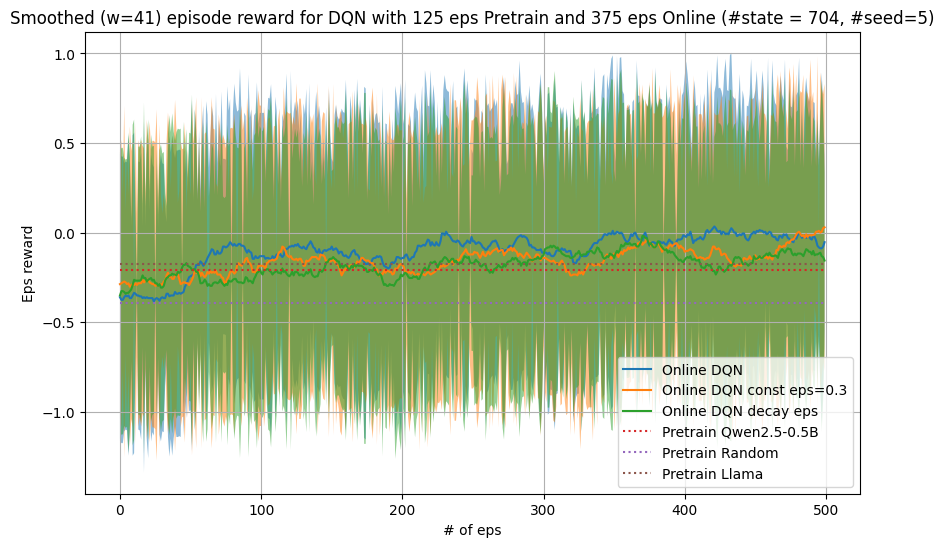

In [14]:
x = range(n_pretrain_eps + n_online_eps)
def moving_average(data, window_size):
    """Compute moving average using convolution."""
    window = np.ones(window_size) / window_size
    # return np.convolve(data, window, mode='valid')
    half_window = window_size // 2
    new_data = np.pad(data, (half_window, half_window), mode='reflect')  # Pad data to handle edges
    return np.convolve(new_data, window, mode='valid')

mean_llama_LORO = np.mean(llama_LORO_rewards, axis = 1)
std_llama_LORO = np.std(llama_LORO_rewards, axis = 1)
mean_Qwen_LORO = np.mean(Qwen_LORO_rewards, axis = 1)
std_Qwen_LORO = np.std(Qwen_LORO_rewards, axis = 1)
mean_rand_LORO = np.mean(rand_LORO_rewards, axis = 1)
std_rand_LORO = np.std(rand_LORO_rewards, axis = 1)
mean_onl = np.mean(onl_rewards, axis = 1)
std_onl = np.std(onl_rewards, axis = 1)
mean_onl_eps = np.mean(onl_rewards_eps, axis = 1)
std_onl_eps = np.std(onl_rewards_eps, axis = 1)
mean_onl_eps_decay = np.mean(onl_rewards_eps_decay, axis = 1)
std_onl_eps_decay = np.std(onl_rewards_eps_decay, axis = 1)

mean_Qwen_LORO[:n_pretrain_eps] = Qwen_avg[:n_pretrain_eps]
mean_llama_LORO[:n_pretrain_eps] = llama_avg[:n_pretrain_eps]
mean_rand_LORO[:n_pretrain_eps] = rand_avg[:n_pretrain_eps]

# Smooth the data
window_size = 41  # Must be an odd number
Qwen_LORO_y_smooth = moving_average(mean_Qwen_LORO, window_size)
rand_LORO_y_smooth = moving_average(mean_rand_LORO, window_size)
llama_LORO_y_smooth = moving_average(mean_llama_LORO, window_size)
onl_y_smooth = moving_average(mean_onl, window_size)
onl_y_eps_smooth = moving_average(mean_onl_eps, window_size)
onl_y_eps_decay_smooth = moving_average(mean_onl_eps_decay, window_size)

# std_onl = std_onl[window_size//2:-window_size//2 + 1]
# std_rand_LORO = std_rand_LORO[window_size//2:-window_size//2 + 1]
# std_Qwen_LORO = std_Qwen_LORO[window_size//2:-window_size//2 + 1]
# std_llama_LORO = std_llama_LORO[window_size//2:-window_size//2 + 1]
# x_smooth = x[window_size//2:-window_size//2 + 1]
x_smooth = x

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(onl_y_smooth, label='Online DQN')
plt.fill_between(x_smooth, onl_y_smooth-std_onl, onl_y_smooth+std_onl, alpha=0.5)
plt.plot(onl_y_eps_smooth, label='Online DQN const eps=0.3')
plt.fill_between(x_smooth, onl_y_eps_smooth-std_onl_eps, onl_y_eps_smooth+std_onl_eps, alpha=0.5)
plt.plot(onl_y_eps_decay_smooth, label='Online DQN decay eps')
plt.fill_between(x_smooth, onl_y_eps_decay_smooth-std_onl, onl_y_eps_decay_smooth+std_onl, alpha=0.5)
# plt.plot(Qwen_LORO_y_smooth, label='Finetune Qwen')
# plt.fill_between(x_smooth, Qwen_LORO_y_smooth-std_Qwen_LORO, Qwen_LORO_y_smooth+std_Qwen_LORO, alpha=0.5)
# plt.plot(rand_LORO_y_smooth, label='Finetune Rand')
# plt.fill_between(x_smooth, rand_LORO_y_smooth-std_rand_LORO, rand_LORO_y_smooth+std_rand_LORO, alpha=0.5)
# plt.plot(llama_LORO_y_smooth, label='Finetune Llama')
# plt.fill_between(x_smooth, llama_LORO_y_smooth-std_llama_LORO, llama_LORO_y_smooth+std_llama_LORO, alpha=0.5)

plt.plot(Qwen_avg, label='Pretrain Qwen2.5-0.5B', linestyle=':')
plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
plt.plot(llama_avg, label='Pretrain Llama', linestyle=':')

# Customize the plot
plt.title(f'Smoothed (w={window_size}) episode reward for DQN with {n_pretrain_eps} eps Pretrain and {n_online_eps} eps Online (#state = 704, #seed={n_exp})')
plt.xlabel('# of eps')
plt.ylabel('Eps reward')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()